# Project 2: Ames Housing Data Challenge


### Problem Statement
* We are real estate agents which are using the Ames housing data to create a regression model that predicts the price of houses in Ames, IA. 
* Understanding what features have strong correlation to houses prices in Ames.
* Update housing estate investors and potential homeowners in Ames.
* Build machine learning models to describe the local housing market and to use these models to predict house prices in that market

### Executive Summary

These are the models that we have tested to understand the correlation on the Ames Iowa data set features and its sale price.

| Model            | Penalty     | Value of a | Training Acuracy | Testing Acuracy | RMSE   | Interpretation/Conclusion                                                                                                                           |
|:------------------|:-------------|:------------:|:------------------|:-----------------|:--------|:-----------------------------------------------------------------------------------------------------------------------------------------------------|
| linear regession | NA          | NA         | -1696222         | -1600552        | 0.1561 | 15 features. train and test score is negative which is a poor fit to the model.                                                                     |
| pipe1_ridge      | RIDGE       | 18.31      | 0.8750           | 0.8594          | 0.1559 | 15 features. train and test score better than linear reg, RMSE on the lower side which is better as well.                                           |
| pipe1_lasso      | LASSO       | 0.01       | 0.8722           | 0.8543          | 0.1587 | 15 features. train and test score slightly lower than ridge. RMSE also higher than ridge. Ridge has better fit and accuracy.                        |
| pipe1_elasticnet | ELASTIC NET | 0.5        | 0.8310           | 0.8102          | 0.1811 | 15 features. train and test score lower than both ridge and lasso. RMSE also higher than ridge and lasso. Ridge has better fit and accuracy.        |
| pipe2_ridge      | RIDGE       | 11.50         | 0.8776            | 0.8633          | 0.1538 | 14 features+ skewness correction. Combined features give better R2 score for train and test. RMSE is also lower in the reduced feature ridge model. |

### Data Cleaning and EDA

In [1]:
# traditional mandate of imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# sklearn: Import Logistic Regression model.
from sklearn.linear_model import LogisticRegression

# sklearn: Import metrics.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

In [2]:
# import files:
filepath_trainset='./datasets/train.csv'
Ames_train=pd.read_csv(filepath_trainset)
filepath_testset='./datasets/test.csv'
Ames_test=pd.read_csv(filepath_testset)

Ames_train.info()

In [3]:
Ames_train.isnull().sum().sort_values(ascending=False)[:27]

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Qual        114
Garage Yr Blt      114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Cars          1
Mo Sold              0
dtype: int64

### Missing data
Theres a few features with more than 1000 data missing from total of 2051 entries and thats Pool QC, Fence, Misc Feature and alley. They will be dropped due to insufficient data to make meaningful correlation study.



### Classifying data into categories

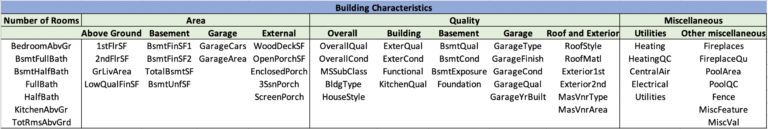

source: https://nycdatascience.com/blog/student-works/house-price-prediction-in-ames-iowa/

From the 81 columns, SalePrice is the target, PID is the identifier and the remaining 79 columns are the features used in the modeling. Given the large number of features, we have to group them by the type of attributes captured by them. 

The features were grouped as follows:
* Year of sale - 1 column 
* Month of sale - 1 column
* Neighborhood characteristics - 4 columns 
* External/lot characteristics - 9 columns
* Building characteristics - 62 columns 
* Number of rooms (7 columns)
* Area (15 columns):
    * Above ground (4), Basement (4), Garage (2), External (5)
* Quality (28 columns):
    * Overall building (7), Building (4), Basement (6), Garage (5), Roof and Exterior (6)
* Miscellaneous (12 columns):
    * Utilities (5), Other (7)
* Sale Type/Cond - 2 columns

# Data Dictionary
| Data Item 	| Category 	| Column Name 	| Data Type 	| Description 	|
|:---	|:---	|:---	|:---	|:---	|
| Location 	| Location 	| PID<br><br>MS Zoning 	| -Nominal<br><br>-Nominal 	| Parcel Identification Number<br><br>General zoning classification of sale 	|
| Sales Price 	| Sales Price 	| Sales Price 	| -Continuous 	| Property Sale Price 	|
| Distance from lot to street 	| Accessibility 	| Lot Front 	| -Continuous 	| Lot Frontage: Linear feet of street connected to property 	|
| Lot Size 	| Lot Size 	| Lot Area 	| -Continuous 	| Lot Area: Lot Size in square feet 	|
| No of Rooms 	| Number of Rooms 	| Bedroom AbvGr<br><br>BsmtFullBath<br><br>BsmtHalfBath<br><br>Full Bath<br><br>Half Bath<br><br>KitchenAbvGr<br><br>TotRmsAbvGrd 	| -Discrete<br><br>-Discrete<br><br>-Discrete<br><br>-Discrete<br><br>-Discrete<br><br>-Discrete<br><br>-Discrete 	| -Bedrooms above grade (does not include basement bedrooms)<br><br>-Basement full bathrooms<br><br>-Basement half bathrooms<br><br>-Full bathrooms above grade<br><br>-Half bathrooms above grade<br><br>-Kitchen above grade<br><br>-Total rooms above grade 	|
| Area above ground 	| Above Ground 	| 1stFlrSF<br><br>2ndFlrSF<br><br>GrLivArea<br><br>LowQualFinSF 	| -Continuous<br><br>-Continuous<br><br>-Continuous<br><br>-Continuous 	| -First floor square feet<br><br>-Second floor square feet<br><br>-Above ground living area<br><br>-Low quality finished square feet (all floors) 	|
| Area of basement 	| Basement 	| BsmtFinSF1<br><br>BsmtFinSF2<br><br>TotalBsmtSF<br><br>BsmtUnfSF<br><br>BsmtFinType2 	| -Continous<br><br>-Ordinal<br><br>-Continuous<br><br>-Continuous<br><br>-Ordinal 	| -Type 1 finished sqft<br><br>-Type 2 finished sqft<br><br>-Total sqft basement area<br><br>-Unfinished sqft basement area<br><br>-Rating of basement finished area (if multiple types) 	|
| Area of garage 	| Garage 	| GarageCars<br><br>GarageArea 	| -Discrete<br><br>-Continuous 	| -Size of garage in car capacity<br><br>-Size of garage in sqft 	|
| External area 	| External Area 	| WoodDeckSF<br><br>OpenPorchSF<br><br>EnclosedPorch<br><br>3SsnPorch<br><br>ScreenPorch 	| -Continuous<br><br>-Continuous<br><br>-Continuous<br><br>-Continuous<br><br>-Continuous 	| -Wood deck area in sqft<br><br>-Open porch area in sqft<br><br>-Enclosed porch area in sqft<br><br>-three season porch area in sqft<br><br>-Screen porch area in sqft 	|
| Overall Quality 	| Overall Quality 	| OverallQual<br><br>OverallCond<br><br>MSSubClass<br><br>BldgType<br><br>HouseStyle 	| -Ordinal<br><br>-Ordinal<br><br>-Nominal<br><br>-Nominal<br><br>-Nominal 	| -Rates overall material and finish of the house<br><br>-Rates overall condition of the house<br><br>-Identifies type of dwelling<br><br>-Type if dwelling<br><br>-Style of dwelling 	|
| Building Quality 	| Building Quality 	| ExterQual<br><br>ExterCond<br><br>Functional<br><br>KitchenQual 	| -Ordinal<br><br>-Ordinal<br><br>-Ordinal<br><br>-Ordinal 	| -Evaluates the quality of the material on the exterior<br><br>-Evaluates the present condition of the material on the exterior<br><br>-Home functionality<br><br>-Kitchen quality 	|
| Basement Quality 	| Basement Quality 	| BsmtQual<br><br>BsmtCond<br><br>BsmtExposure<br><br>Foundation 	| -Ordinal<br><br>-Ordinal<br><br>-Ordinal<br><br>-Nominal 	| -Evaluates height of basement<br><br>-Evaluates general condition of basement<br><br>-Refers to walkout or garden level walls<br><br>-Type of foundation 	|
| Garage Quality 	| Garage Quality 	| GarageType<br><br>GarageFinish<br><br>GarageCond<br><br>GarageQual<br><br>GarageYrBuilt 	| -Nominal<br><br>-Ordinal<br><br>-Ordinal<br><br>-Ordinal<br><br>-Discrete 	| -Garage location<br><br>-Interior finish of the garage<br><br>-Garage condition<br><br>-Garage quality<br><br>-Year garage was built 	|
| Roof and Exterior Quality 	| Roof and Exterior Quality 	| RoofStyle<br><br>RoofMatl<br><br>Exterior1st<br><br>Exterior2nd<br><br>MasVnrType<br><br>MasVnrArea 	| -Nominal<br><br>-Nominal<br><br>-Nominal<br><br>-Nominal<br><br>-Nominal<br><br>-Continuous 	| -Type of roof<br><br>-Roof material<br><br>-Exterior covering on house<br><br>-Exterior covering on house (if more than 1 material)<br><br>-Masonry veneer type<br><br>-Masonry veneer area in sqft 	|
| Misc Quality 	| Miscellaneous Utilities 	| Heating<br><br>HeatingQC<br><br>CentralAir<br><br>Electrical<br><br>Utilities 	| -Nominal<br><br>-Ordinal<br><br>-Nominal<br><br>-Ordinal<br><br>-Ordinal 	| -Type of heating<br><br>-Heating quality and condition<br><br>-Central air conditioning<br><br>-ELectrical system<br><br>-Type of utilities available 	|
| Other Misc 	| Other Miscellaneous 	| Fireplaces<br><br>FireplaceQu<br><br>PoolArea<br><br>PoolQC<br><br>Fence<br><br>MiscFeature<br><br>MiscVal<br><br>Street<br><br>Alley<br><br>Land Contour 	| -Discrete<br><br>-Ordinal<br><br>-Continuous<br><br>-Ordinal<br><br>-Ordinal<br><br>-Nominal<br><br>-Continuous<br><br>-Nominal<br><br>-Nominal<br><br>-Nominal 	| -Number of fireplaces<br><br>-Fireplace quality<br><br>-Pool area in sqft<br><br>-Pool quality<br><br>-Fence quality<br><br>-Miscellaneous feature not covered in other categories<br><br>-value of miscellaneous feature<br><br>-Type of of road access to property<br><br>-Type of alley access to property<br><br>-Flatness of property 	|

#### Documentation of the data:
source: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [4]:
Ames_train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [5]:
Ames_train.drop(axis=1,columns=['Pool QC','Fence','Alley','Misc Feature'],inplace=True)

In [6]:
Ames_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,...,59,0,0,0,0,0,3,2010,WD,138500


In [7]:
#Checking the missing values for mas veneer area by looking at mas veneer type.
veneer_pack=['Mas Vnr Type', 'Mas Vnr Area']
veneer_null=Ames_train[veneer_pack][Ames_train[veneer_pack].isna().any(axis=1)]
pd.set_option('display.max_rows', None)
veneer_null

#all the rows have no veneer info for type and area. we will assume there is no veneer used.

,Mas Vnr Type,Mas Vnr Area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN
338,NaN,NaN
431,NaN,NaN
451,NaN,NaN
591,NaN,NaN
844,NaN,NaN


In [8]:
#looking into detail the related features.
Garage_pack=['Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond']
Garage_null=Ames_train[Garage_pack][Ames_train[Garage_pack].isna().any(axis=1)]
pd.set_option('display.max_rows', None)
Garage_null[:4]

#looks like all the rows are null for garage. we will assume that the house does not have any garage.

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
28,NaN,NaN,NaN,0.0,0.0,NaN,NaN
53,NaN,NaN,NaN,0.0,0.0,NaN,NaN
65,NaN,NaN,NaN,0.0,0.0,NaN,NaN
79,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [9]:
Garage_null.loc[1712]

Garage Type      Detchd
Garage Yr Blt       NaN
Garage Finish       NaN
Garage Cars         NaN
Garage Area         NaN
Garage Qual         NaN
Garage Cond         NaN
Name: 1712, dtype: object

In [10]:
#mainly to unitize the data so that all the other garage features is NA 
Ames_train.loc[1712,'Garage Type'] = np.nan
#replace the garage cars and area to 0
Ames_train.loc[1712,'Garage Cars'] = 0
Ames_train.loc[1712,'Garage Area'] = 0

In [11]:
#looking into detail the related features.
Bsmt_pack=['Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF','Bsmt Half Bath','Bsmt Full Bath']
Bsmt_null=Ames_train[Bsmt_pack][Ames_train[Bsmt_pack].isna().any(axis=1)]
Bsmt_null
#basement there are some missing values here and there. we will substitute according to the other columns information.

,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Half Bath,Bsmt Full Bath
12,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
93,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
114,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
146,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
183,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
240,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
249,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
256,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
390,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
437,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [12]:
#rows of interest
row_index_bsmt_missing=[616,1147,1327,1456,1547,1997]
Bsmt_null.loc[row_index_bsmt_missing]

,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Half Bath,Bsmt Full Bath
616,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
1147,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,0.0,1.0
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


In [13]:
#for 1147 basement type 2 was unfinished. instead of NaN it should be categorized as unfinished since there are values of unfinished square foot for bsmt 2.
#replace to unf in the main Ames dataset
Ames_train.loc[1147,'BsmtFin Type 2'] = 'Unf'
Ames_train.loc[1147,'BsmtFin Type 2']

'Unf'

In [14]:
#row 616 and 1327 theres no data at all but assuming there was no garage thats why row was left empty.
#replace the numerical features from Na to 0
bsmt_sqft_set=['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','Bsmt Half Bath','Bsmt Full Bath']
Ames_train.loc[616,bsmt_sqft_set] = 0
Ames_train.loc[1327,bsmt_sqft_set] = 0
Ames_train.loc[616,bsmt_sqft_set]

BsmtFin SF 1      0.0
BsmtFin SF 2      0.0
Bsmt Unf SF       0.0
Total Bsmt SF     0.0
Bsmt Half Bath    0.0
Bsmt Full Bath    0.0
Name: 616, dtype: object

In [15]:
Ames_train.loc[1327,bsmt_sqft_set]

BsmtFin SF 1      0.0
BsmtFin SF 2      0.0
Bsmt Unf SF       0.0
Total Bsmt SF     0.0
Bsmt Half Bath    0.0
Bsmt Full Bath    0.0
Name: 1327, dtype: object

In [16]:
#for row index 1456,1547,1997 means no basement since its not built yet. Ill leave it as NaN

In [17]:
Fireplace_pack=['Fireplaces', 'Fireplace Qu']
Fireplace_null=Ames_train[Fireplace_pack][Ames_train[Fireplace_pack].isna().any(axis=1)]
Fireplace_null[:5]

#Fireplace quality is really representing no fireplace. we will leave it as NaN.

,Fireplaces,Fireplace Qu
0,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
6,0,NaN


In [18]:
#nominal feautres set
nom_features = ['MS Zoning','Street','Lot Config','Land Contour','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Sale Type']


In [19]:
nom_set_df=Ames_train[nom_features]

In [20]:
nom_set_dummified = pd.get_dummies(data=nom_set_df,columns=nom_features,drop_first=True)

In [21]:
nom_set_dummified.head()

,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,...,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [22]:
from sklearn.impute import KNNImputer

In [23]:
knn_imp = KNNImputer()
knn_imp_nom_set = knn_imp.fit_transform(nom_set_dummified)

knn_imp_nom_set = pd.DataFrame(knn_imp_nom_set, columns = nom_set_dummified.columns)

In [24]:
# Ordinal Features list
ord_features = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Overall Qual','Overall Cond']
# Create ordinal DataFrame
ordinals = Ames_train[ord_features].fillna('NA')



In [25]:
ordinals.head()

,Lot Shape,Utilities,Land Slope,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Overall Qual,Overall Cond
0,IR1,AllPub,Gtl,Gd,TA,TA,TA,No,GLQ,Unf,...,SBrkr,Gd,Typ,NA,RFn,TA,TA,Y,6,8
1,IR1,AllPub,Gtl,Gd,TA,Gd,TA,No,GLQ,Unf,...,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,7,5
2,Reg,AllPub,Gtl,TA,Gd,TA,TA,No,GLQ,Unf,...,SBrkr,Gd,Typ,NA,Unf,TA,TA,Y,5,7
3,Reg,AllPub,Gtl,TA,TA,Gd,TA,No,Unf,Unf,...,SBrkr,TA,Typ,NA,Fin,TA,TA,Y,5,5
4,IR1,AllPub,Gtl,TA,TA,Fa,Gd,No,Unf,Unf,...,SBrkr,TA,Typ,NA,Unf,TA,TA,N,6,8


In [26]:
ordinals['Fireplace Qu'].unique()

array(['NA', 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

In [27]:
#checking the number of unique values for the ordinal feautres. it seems that they have different scales.(5,6,etc)
unique_df=pd.DataFrame(ordinals['Fireplace Qu'].unique(),columns=['Fireplace Qu'])
unique_df['Functional']=pd.Series(ordinals['Functional'].unique())
unique_df

,Fireplace Qu,Functional
0,NA,Typ
1,TA,Mod
2,Gd,Min2
3,Po,Maj1
4,Ex,Min1
5,Fa,Sev


In [28]:
# Create dictionaries for mapping standardized category labels 
# Some features already had these labels and were not mapped
order_lotshape = {'Reg':'Ex','IR1':'Gd','IR2':'TA',
'IR3':'Fa','NA':'NA'}
order_util = {'AllPub':'Ex','NoSewr':'Gd',
'NoSeWa':'TA','ELO':'Fa','NA':'NA'}
order_landslope = {'Gtl':'Ex','Mod':'Gd',
'Sev':'TA','NA':'NA'}
order_bsFin = {'GLQ':'Ex','ALQ':'Gd','BLQ':'TA',
'Rec':'Fa','LwQ':'Po','Unf':'Po','NA':'NA'}
order_elec = {'SBrkr':'Ex','FuseA':'Gd','FuseF':'TA',
'FuseP':'Fa','Mix':'Po','NA':'NA'}
order_func = {'Typ':'Ex','Min1':'Gd','Min2':'TA','Mod':'Fa',
'Maj1':'Po','Maj2':'Po','Sev':'Po','Sal':'Po','NA':'NA'}
order_garage_fin = {'Fin':'Ex','RFn':'Gd','Unf':'TA','NA':'NA'}
order_paved = {'Y':'Ex','P':'Gd','N':'TA','NA':'NA'}
order_map_Qual = {10:'Ex',9:'Ex',8:'Gd',7:'Gd',6:'Gd',5:'TA',
4:'TA',3:'Fa',2:'Po',1:'Po','NA':'NA'}
order_bsmt_Exposure={'Gd':'Gd','Av':'TA','Mn':'Fa', 'No':'Po','NA' :'NA'}
order_Fireplace_Qu={'Ex':'Ex','Gd':'Gd','TA':'TA','Fa':'Fa', 'Po':'Po','NA' :'NA'}
# Map labels to features
ordinals['Lot Shape'] = ordinals['Lot Shape'].map(order_lotshape)
ordinals['Utilities'] = ordinals['Utilities'].map(order_util)
ordinals['Land Slope'] = ordinals['Land Slope'].map(order_landslope)
ordinals['BsmtFin Type 1'] = ordinals['BsmtFin Type 1'].map(order_bsFin)
ordinals['BsmtFin Type 2'] = ordinals['BsmtFin Type 2'].map(order_bsFin)
ordinals['Electrical'] = ordinals['Electrical'].map(order_elec)
ordinals['Functional'] = ordinals['Functional'].map(order_func)
ordinals['Garage Finish'] = ordinals['Garage Finish'].map(order_garage_fin)
ordinals['Paved Drive'] = ordinals['Paved Drive'].map(order_paved)
ordinals['Overall Qual'] = ordinals['Overall Qual'].map(order_map_Qual)
ordinals['Overall Cond'] = ordinals['Overall Cond'].map(order_map_Qual)
ordinals['Bsmt Exposure']= ordinals['Bsmt Exposure'].map(order_bsmt_Exposure)
ordinals['Fireplace Qu']= ordinals['Fireplace Qu'].map(order_Fireplace_Qu)


In [29]:
# Map the ordinal categories to numbers in a 1 to 5 scale.
number_cats = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
for col in ordinals.columns:
    ordinals[col] = ordinals[col].map(number_cats)

In [30]:
ordinals.head()

,Lot Shape,Utilities,Land Slope,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Overall Qual,Overall Cond
0,4,5,5,4,3,3,3,1,5,1,...,5,4,5,0,4,3,3,5,4,4
1,4,5,5,4,3,4,3,1,5,1,...,5,4,5,3,4,3,3,5,4,3
2,5,5,5,3,4,3,3,1,5,1,...,5,4,5,0,3,3,3,5,3,4
3,5,5,5,3,3,4,3,1,1,1,...,5,3,5,0,5,3,3,5,3,3
4,4,5,5,3,3,2,4,1,1,1,...,5,3,5,0,3,3,3,3,4,4


In [31]:
pd.Series(ordinals['Functional'].unique()).sort_values(ascending=True)

3    1
1    2
2    3
4    4
0    5
dtype: int64

In [32]:
#checking the number of unique values for the ordinal feautres. it seems that they have different scales.
unique_scaled_df1=pd.DataFrame(ordinals['Fireplace Qu'].unique(),columns=['Fireplace Qu'])
unique_scaled_df2=pd.DataFrame(ordinals['Fireplace Qu'].unique(),columns=['Functional'])
unique_scaled_df=pd.concat([unique_scaled_df1,unique_scaled_df2],axis=1)
unique_scaled_df.sort_values(ascending=True,by='Fireplace Qu')

,Fireplace Qu,Functional
0,0,0
3,1,1
5,2,2
1,3,3
2,4,4
4,5,5


In [33]:
#These final steps were taken to get our data ready for modeling with all categorical features now encoded.
# drop earlier unencoded ordinal features
Ames_train_clean_df = Ames_train.drop(columns=ord_features).copy()
# Combine encoded ordinals
Ames_train_clean_df = pd.concat([Ames_train_clean_df,ordinals],axis=1)
Ames_train_clean_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Land Contour,Lot Config,Neighborhood,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Overall Qual,Overall Cond
0,109,533352170,60,RL,NaN,13517,Pave,Lvl,CulDSac,Sawyer,...,5,4,5,0,4,3,3,5,4,4
1,544,531379050,60,RL,43.0,11492,Pave,Lvl,CulDSac,SawyerW,...,5,4,5,3,4,3,3,5,4,3
2,153,535304180,20,RL,68.0,7922,Pave,Lvl,Inside,NAmes,...,5,4,5,0,3,3,3,5,3,4
3,318,916386060,60,RL,73.0,9802,Pave,Lvl,Inside,Timber,...,5,3,5,0,5,3,3,5,3,3
4,255,906425045,50,RL,82.0,14235,Pave,Lvl,Inside,SawyerW,...,5,3,5,0,3,3,3,3,4,4


In [34]:
#Lets replace the nominal values as well.
Ames_train_clean_df = Ames_train_clean_df.drop(columns=nom_features).copy()
# Combine encoded ordinals
Ames_train_clean_df = pd.concat([Ames_train_clean_df,knn_imp_nom_set],axis=1)
Ames_train_clean_df.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,533352170,60,NaN,13517,1976,2005,289.0,533.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,544,531379050,60,43.0,11492,1996,1997,132.0,637.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,153,535304180,20,68.0,7922,1953,2007,0.0,731.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,318,916386060,60,73.0,9802,2006,2007,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,255,906425045,50,82.0,14235,1900,1993,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
num_df=Ames_train.drop(columns=nom_features).copy()

In [36]:
num_df=num_df.drop(columns=ord_features).copy()


In [37]:
num_df.columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars',
       'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold', 'SalePrice'],
      dtype='object')

In [38]:
#drop ID, PID and salesprice since no missing and is irrelevant to the feature data
num_df=num_df.drop(columns=['Id', 'PID']).copy()

In [39]:
num_df.head()

,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,60,NaN,13517,1976,2005,289.0,533.0,0.0,192.0,725.0,...,0,44,0,0,0,0,0,3,2010,130500
1,60,43.0,11492,1996,1997,132.0,637.0,0.0,276.0,913.0,...,0,74,0,0,0,0,0,4,2009,220000
2,20,68.0,7922,1953,2007,0.0,731.0,0.0,326.0,1057.0,...,0,52,0,0,0,0,0,1,2010,109000
3,60,73.0,9802,2006,2007,0.0,0.0,0.0,384.0,384.0,...,100,0,0,0,0,0,0,4,2010,174000
4,50,82.0,14235,1900,1993,0.0,0.0,0.0,676.0,676.0,...,0,59,0,0,0,0,0,3,2010,138500


In [40]:
num_df.isnull().sum().sort_values(ascending=False)[:20]

#Lot frontage, Garage year built and Mas Vnr Area missing values are indicating no garage or mas vnr area.

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Open Porch SF       0
TotRms AbvGrd       0
Fireplaces          0
Garage Cars         0
Garage Area         0
Wood Deck SF        0
MS SubClass         0
Kitchen AbvGr       0
3Ssn Porch          0
Screen Porch        0
Pool Area           0
Misc Val            0
Mo Sold             0
Yr Sold             0
Enclosed Porch      0
Half Bath           0
Bedroom AbvGr       0
dtype: int64

In [41]:
num_df['SalePrice'].isnull().sum()

0

In [42]:
#checking any errors in the years
num_df['Year Remod/Add'].sort_values(ascending=False)[:10]

172     2010
142     2010
369     2010
398     2010
70      2010
1241    2010
1671    2010
144     2010
139     2009
212     2009
Name: Year Remod/Add, dtype: int64

In [43]:
#checking any errors in the years
num_df['Year Built'].sort_values(ascending=False)[:10]

144     2010
1238    2009
625     2009
1241    2009
1671    2009
1732    2009
1741    2009
172     2009
70      2009
637     2009
Name: Year Built, dtype: int64

In [44]:
num_df['Garage Yr Blt'].sort_values(ascending=False)[:10]

1699    2207.0
1241    2010.0
144     2010.0
1700    2009.0
1732    2009.0
398     2009.0
1238    2009.0
589     2009.0
369     2009.0
1060    2009.0
Name: Garage Yr Blt, dtype: float64

In [45]:
#notice theres a 2207 year which doesnt make sense unless we are predicting houses that will be built in the future

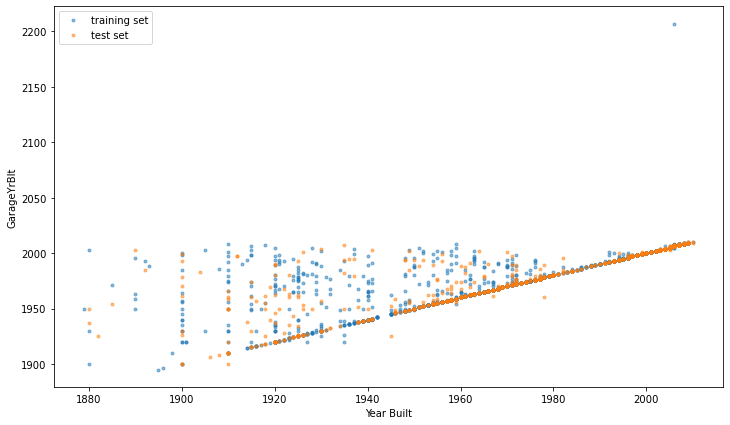

In [46]:
#check relationship between year built and garage year built.
plt.figure(figsize=(12,7))
plt.xlabel("Year Built")
plt.ylabel("GarageYrBlt")
plt.plot(Ames_train['Year Built'], Ames_train['Garage Yr Blt'],'.', alpha=0.5, label = 'training set')
plt.plot(Ames_test['Year Built'], Ames_test['Garage Yr Blt'],'.', alpha=0.5, label = 'test set') 
plt.legend();

In [47]:
Ames_train.loc[1699,Bsmt_pack]

Bsmt Cond             TA
Bsmt Exposure         Av
BsmtFin Type 1       GLQ
BsmtFin SF 1       583.0
BsmtFin Type 2       Unf
BsmtFin SF 2         0.0
Bsmt Unf SF        963.0
Total Bsmt SF     1546.0
Bsmt Half Bath       0.0
Bsmt Full Bath       0.0
Name: 1699, dtype: object

In [48]:
year_set=['Garage Yr Blt','Year Built']
Ames_train.loc[1699,year_set]

#the year built makes more sense. we will replace the garage year built to 2006 instead since the garage type 1 is already built and in GLQ.

Garage Yr Blt    2207.0
Year Built         2006
Name: 1699, dtype: object

In [49]:
Ames_train.loc[1699,'Garage Yr Blt']=2006
Ames_train.loc[1699,'Garage Yr Blt']

2006.0

In [50]:
Ames_train_clean_df.loc[1699,'Garage Yr Blt']=2006
Ames_train_clean_df.loc[1699,'Garage Yr Blt']

2006.0

In [51]:
#Another point is since the regression fit cnt run with too many NaN values especially from garage yr built.
#decision was made to impute missing values in garage yr built with house year built since theres no benefit or penalty of doing so.
Ames_train_clean_df['Garage Yr Blt'].fillna(Ames_train_clean_df['Year Built'],inplace=True)
Ames_train['Garage Yr Blt'].fillna(Ames_train['Year Built'],inplace=True)

In [52]:
#since no data cleaning needed for numerical features. this is the final cleaned df we will be using.
Ames_train_clean_df.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,533352170,60,NaN,13517,1976,2005,289.0,533.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,544,531379050,60,43.0,11492,1996,1997,132.0,637.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,153,535304180,20,68.0,7922,1953,2007,0.0,731.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,318,916386060,60,73.0,9802,2006,2007,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,255,906425045,50,82.0,14235,1900,1993,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


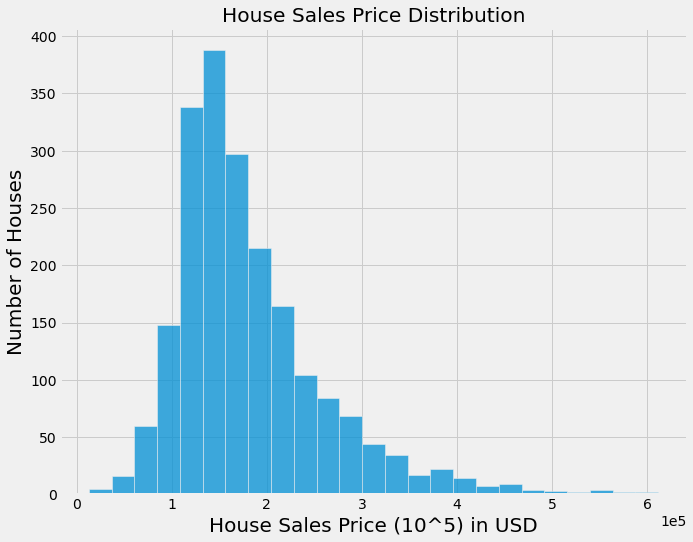

In [53]:
#Checking the distribution of the target variable: SalesPrice
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
sns.histplot(Ames_train_clean_df['SalePrice'], bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price (10^5) in USD",size=20)
plt.ylabel("Number of Houses",size=20)
plt.title("House Sales Price Distribution");

In [54]:
print(f'Skew: {Ames_train_clean_df.SalePrice.skew()}')
print("Kurtosis: %f" % Ames_train_clean_df.SalePrice.kurt())

Skew: 1.5575514385863427
Kurtosis: 3.579003


We can see that our target variable is skewed to the right, towards the more expensive homes, with higher concentration on cheaper homes.


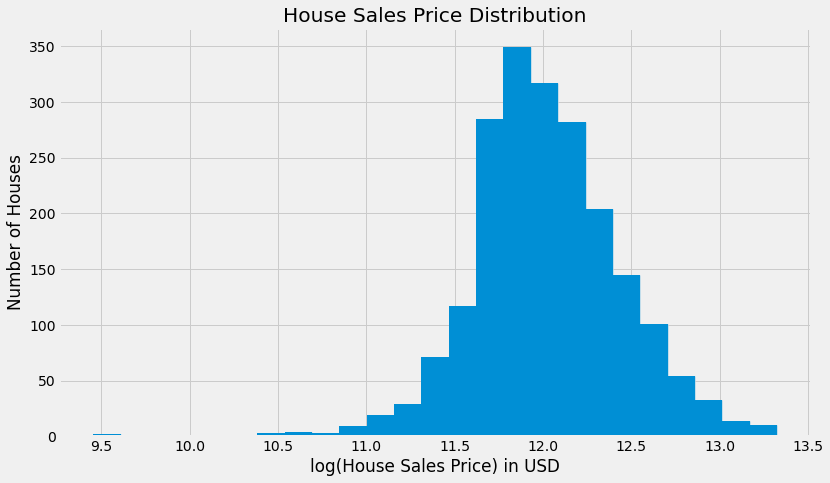

In [55]:
#To make this distribution more symmetrical, we can try taking its logarithm.
#Logarithimic distribution of the target variable : SalesPrice
plt.figure(figsize=(12,7))
sns.histplot(np.log(Ames_train_clean_df['SalePrice']), bins = 25);
plt.xlabel("log(House Sales Price) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")
plt.hist(np.log(Ames_train_clean_df['SalePrice']), bins = 25);

In [56]:
print("Skew is:", np.log(Ames_train_clean_df['SalePrice']).skew())
print("Kurtosis: %f" % np.log(Ames_train_clean_df['SalePrice']).kurt())

Skew is: -0.14681576272177396
Kurtosis: 1.885284


With logarithm sales price the distribution is closer to normal.

In [57]:
#Taking the logarithm from our target variable, we obtain something similar to a Gaussian distribution. This will ensure that relative errors for cheaper and more expensive homes are treated on an equal footing. Moreover, if we take a look at the evaluation metric for the Kaggle competition we see that “ Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.” Hence, we must assumelog(SalePrice)as our true target variable.
#Converting SalePrice to log value
Ames_train_clean_df['SalePrice'] = np.log(Ames_train_clean_df['SalePrice'])

In [58]:
Ames_train_clean_df['SalePrice'].mode()

0    11.77529
dtype: float64

In [59]:
Ames_train_clean_df['SalePrice'].mean()

12.024396927855056

In [60]:
Ames_train_clean_df['SalePrice'].median()

11.998433280751929

The mode, mean , median for train set salesprice are closer with log sales price.

### Similar data cleaning for test set.

In [61]:
Ames_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [62]:
Ames_test.isnull().sum().sort_values(ascending=False)[:20]

Pool QC           874
Misc Feature      837
Alley             820
Fence             706
Fireplace Qu      422
Lot Frontage      160
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Garage Type        44
BsmtFin Type 1     25
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 2     25
Electrical          1
Mas Vnr Type        1
Mas Vnr Area        1
Kitchen AbvGr       0
dtype: int64

In [63]:
#similarly, we drop Pool QC, Misc Feature, Alley and Fence
Ames_test=Ames_test.drop(columns=['Pool QC', 'Misc Feature','Alley','Fence']).copy()

In [64]:
Ames_test['Garage Yr Blt'].sort_values(ascending=False)[:10]

315    2010.0
452    2010.0
316    2010.0
696    2009.0
847    2009.0
40     2009.0
608    2009.0
244    2009.0
730    2009.0
394    2009.0
Name: Garage Yr Blt, dtype: float64

In [65]:
#Another point is since the regression fit cnt run with too many NaN values especially from garage yr built.
#decision was made to impute missing values in garage yr built with house year built since theres no benefit or penalty of doing so.
Ames_test['Garage Yr Blt'].fillna(Ames_test['Year Built'],inplace=True)

In [66]:
Garage_test_null=Ames_test[Garage_pack][Ames_test[Garage_pack].isna().any(axis=1)]
Garage_test_null


,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
29,NaN,1945.0,NaN,0,0,NaN,NaN
45,NaN,1970.0,NaN,0,0,NaN,NaN
66,NaN,1971.0,NaN,0,0,NaN,NaN
68,NaN,1931.0,NaN,0,0,NaN,NaN
105,NaN,1945.0,NaN,0,0,NaN,NaN
109,NaN,1967.0,NaN,0,0,NaN,NaN
113,NaN,2006.0,NaN,0,0,NaN,NaN
144,NaN,1947.0,NaN,0,0,NaN,NaN
152,NaN,1920.0,NaN,0,0,NaN,NaN
156,NaN,1970.0,NaN,0,0,NaN,NaN


the detached garage had values for garage area and cars. we will leave it as detached and go through pd.get dummies

In [67]:
Ames_test.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', '

In [68]:
Bsmt_pack=['Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF','Bsmt Half Bath','Bsmt Full Bath']

In [69]:
bsmt_test_null=Ames_test[Bsmt_pack][Ames_test[Bsmt_pack].isna().any(axis=1)]
bsmt_test_null

,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Half Bath,Bsmt Full Bath
15,NaN,NaN,NaN,0,NaN,0,0,0,0,0
37,NaN,NaN,NaN,0,NaN,0,0,0,0,0
76,NaN,NaN,NaN,0,NaN,0,0,0,0,0
78,NaN,NaN,NaN,0,NaN,0,0,0,0,0
112,NaN,NaN,NaN,0,NaN,0,0,0,0,0
144,NaN,NaN,NaN,0,NaN,0,0,0,0,0
189,NaN,NaN,NaN,0,NaN,0,0,0,0,0
205,NaN,NaN,NaN,0,NaN,0,0,0,0,0
278,NaN,NaN,NaN,0,NaN,0,0,0,0,0
291,NaN,NaN,NaN,0,NaN,0,0,0,0,0


In [70]:
#all empty most likely no basement for all these entries.

In [71]:
#nominal feautres set
nom_test_features = ['MS Zoning','Street','Lot Config','Land Contour','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Sale Type']
nom_test_df=Ames_test[nom_test_features]
nom_set_test_dummified = pd.get_dummies(data=nom_test_df,columns=nom_features,drop_first=True)

In [72]:
nom_set_test_dummified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Columns: 123 entries, MS Zoning_FV to Sale Type_WD 
dtypes: uint8(123)
memory usage: 105.6 KB


In [73]:
nom_test_df.head()

,MS Zoning,Street,Lot Config,Land Contour,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Sale Type
0,RM,Pave,Inside,Lvl,OldTown,Norm,Norm,2fmCon,2Story,Gable,CompShg,AsbShng,AsbShng,None,Stone,GasA,N,Detchd,WD
1,RL,Pave,Inside,Lvl,Sawyer,Norm,Norm,Duplex,1Story,Gable,CompShg,Plywood,Plywood,None,CBlock,GasA,Y,Attchd,WD
2,RL,Pave,Inside,Lvl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,Attchd,New
3,RM,Pave,Inside,Lvl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,WD
4,RL,Pave,Inside,Lvl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,BrkFace,CBlock,GasA,Y,Attchd,WD


In [74]:
nom_set_test_dummified.head()

,MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,...,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,0,0,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [75]:
knn_imp = KNNImputer()
knn_imp_nom_test_set = knn_imp.fit_transform(nom_set_test_dummified)

knn_imp_nom_test_set = pd.DataFrame(knn_imp_nom_test_set, columns = nom_set_test_dummified.columns)

In [76]:
# Ordinal Features list
ord_features = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Overall Qual','Overall Cond']
# Create ordinal DataFrame
ordinals_test = Ames_test[ord_features].fillna('NA')



In [77]:
# Create dictionaries for mapping standardized category labels 
# Some features already had these labels and were not mapped
order_lotshape = {'Reg':'Ex','IR1':'Gd','IR2':'TA',
'IR3':'Fa','NA':'NA'}
order_util = {'AllPub':'Ex','NoSewr':'Gd',
'NoSeWa':'TA','ELO':'Fa','NA':'NA'}
order_landslope = {'Gtl':'Ex','Mod':'Gd',
'Sev':'TA','NA':'NA'}
order_bsFin = {'GLQ':'Ex','ALQ':'Gd','BLQ':'TA',
'Rec':'Fa','LwQ':'Po','Unf':'Po','NA':'NA'}
order_elec = {'SBrkr':'Ex','FuseA':'Gd','FuseF':'TA',
'FuseP':'Fa','Mix':'Po','NA':'NA'}
order_func = {'Typ':'Ex','Min1':'Gd','Min2':'TA','Mod':'Fa',
'Maj1':'Po','Maj2':'Po','Sev':'Po','Sal':'Po','NA':'NA'}
order_garage_fin = {'Fin':'Ex','RFn':'Gd','Unf':'TA','NA':'NA'}
order_paved = {'Y':'Ex','P':'Gd','N':'TA','NA':'NA'}
order_map_Qual = {10:'Ex',9:'Ex',8:'Gd',7:'Gd',6:'Gd',5:'TA',
4:'TA',3:'Fa',2:'Po',1:'Po','NA':'NA'}
order_bsmt_Exposure={'Gd':'Gd','Av':'TA','Mn':'Fa', 'No':'Po','NA' :'Po'}
order_Fireplace_Qu={'Ex':'Ex','Gd':'Gd','TA':'TA','Fa':'Fa', 'Po':'Po','NA' :'NA'}
# Map labels to features
ordinals_test['Lot Shape'] = ordinals_test['Lot Shape'].map(order_lotshape)
ordinals_test['Utilities'] = ordinals_test['Utilities'].map(order_util)
ordinals_test['Land Slope'] = ordinals_test['Land Slope'].map(order_landslope)
ordinals_test['BsmtFin Type 1'] = ordinals_test['BsmtFin Type 1'].map(order_bsFin)
ordinals_test['BsmtFin Type 2'] = ordinals_test['BsmtFin Type 2'].map(order_bsFin)
ordinals_test['Electrical'] = ordinals_test['Electrical'].map(order_elec)
ordinals_test['Functional'] = ordinals_test['Functional'].map(order_func)
ordinals_test['Garage Finish'] = ordinals_test['Garage Finish'].map(order_garage_fin)
ordinals_test['Paved Drive'] = ordinals_test['Paved Drive'].map(order_paved)
ordinals_test['Overall Qual'] = ordinals_test['Overall Qual'].map(order_map_Qual)
ordinals_test['Overall Cond'] = ordinals_test['Overall Cond'].map(order_map_Qual)
ordinals_test['Bsmt Exposure']= ordinals_test['Bsmt Exposure'].map(order_bsmt_Exposure)
ordinals_test['Fireplace Qu']= ordinals_test['Fireplace Qu'].map(order_Fireplace_Qu)

In [78]:
# Map the ordinal categories to numbers in a 1 to 5 scale.
number_cats = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':0,'NA':0}
for col in ordinals_test.columns:
    ordinals_test[col] = ordinals_test[col].map(number_cats)
    

In [79]:
ordinals_test.head()

,Lot Shape,Utilities,Land Slope,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Overall Qual,Overall Cond
0,5,5,5,3,2,2,3,0,0,0,...,2,2,5,0,3,0,0,5,4,4
1,4,5,5,3,3,4,3,0,0,0,...,5,3,5,0,5,3,3,5,3,3
2,4,5,5,4,3,4,4,3,5,0,...,5,4,5,4,4,3,3,5,4,3
3,5,5,5,4,3,3,3,0,0,0,...,5,3,5,0,3,2,3,3,3,4
4,4,5,5,3,3,4,3,0,3,0,...,5,3,5,4,4,3,3,5,4,3


In [80]:
#These final steps were taken to get our data ready for modeling with all categorical features now encoded.
# drop earlier unencoded ordinal features
Ames_test_clean_df = Ames_test.drop(columns=ord_features).copy()
# Combine encoded ordinals
Ames_test_clean_df = pd.concat([Ames_test_clean_df,ordinals_test],axis=1)
Ames_test_clean_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Land Contour,Lot Config,Neighborhood,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Overall Qual,Overall Cond
0,2658,902301120,190,RM,69.0,9142,Pave,Lvl,Inside,OldTown,...,2,2,5,0,3,0,0,5,4,4
1,2718,905108090,90,RL,NaN,9662,Pave,Lvl,Inside,Sawyer,...,5,3,5,0,5,3,3,5,3,3
2,2414,528218130,60,RL,58.0,17104,Pave,Lvl,Inside,Gilbert,...,5,4,5,4,4,3,3,5,4,3
3,1989,902207150,30,RM,60.0,8520,Pave,Lvl,Inside,OldTown,...,5,3,5,0,3,2,3,3,3,4
4,625,535105100,20,RL,NaN,9500,Pave,Lvl,Inside,NAmes,...,5,3,5,4,4,3,3,5,4,3


In [81]:
#Lets replace the nominal values as well.
Ames_test_clean_df = Ames_test_clean_df.drop(columns=nom_test_features).copy()
# Combine encoded ordinals
Ames_test_clean_df = pd.concat([Ames_test_clean_df,knn_imp_nom_test_set],axis=1)
Ames_test_clean_df.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,902301120,190,69.0,9142,1910,1950,0.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2718,905108090,90,NaN,9662,1977,1977,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2414,528218130,60,58.0,17104,2006,2006,0.0,554,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1989,902207150,30,60.0,8520,1923,2006,0.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,625,535105100,20,NaN,9500,1963,1963,247.0,609,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
lotfront_set=Ames_test_clean_df.loc[:, ['Lot Frontage']]
lotfront_set[:5]

,Lot Frontage
0,69.0
1,NaN
2,58.0
3,60.0
4,NaN


In [83]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(strategy='median')
imp_lotfront =imp_median.fit_transform(lotfront_set)
imp_lotfront[:3]

array([[69.],
       [68.],
       [58.]])

In [84]:
# convert above array from imputation operation to a df for downstream operations
lotfront_imp_df = pd.DataFrame(imp_lotfront,columns=lotfront_set.columns)

In [85]:
#Lets replace the nominal values as well.
Ames_test_clean_df = Ames_test_clean_df.drop(columns=['Lot Frontage']).copy()
# Combine encoded ordinals
Ames_test_clean_df = pd.concat([Ames_test_clean_df,lotfront_imp_df],axis=1)
Ames_test_clean_df.head()

,Id,PID,MS SubClass,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Lot Frontage
0,2658,902301120,190,9142,1910,1950,0.0,0,0,1020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,69.0
1,2718,905108090,90,9662,1977,1977,0.0,0,0,1967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.0
2,2414,528218130,60,17104,2006,2006,0.0,554,0,100,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,58.0
3,1989,902207150,30,8520,1923,2006,0.0,0,0,968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,60.0
4,625,535105100,20,9500,1963,1963,247.0,609,0,785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.0


#### Summary Statistics

In [86]:
Ames_train_clean_df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2029.000000,2051.000000,2051.000000,...,2051.000000,2051.000000,2051.000000,2051.00000,2051.000000,2051.000000,2051.000000,2051.000000,2051.00000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,1971.708922,1984.190151,99.695909,442.084837,47.935641,...,0.005363,0.260848,0.004876,0.00195,0.008289,0.003413,0.002438,0.078011,0.00195,0.868357
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,30.177889,21.036250,174.963129,461.195041,164.964052,...,0.073055,0.439204,0.069673,0.04413,0.090686,0.058335,0.049326,0.268254,0.04413,0.338185
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,2001.000000,2004.000000,161.000000,733.500000,0.000000,...,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [87]:
Ames_train_clean_df['SalePrice'].describe()

count    2051.000000
mean       12.024397
std         0.411316
min         9.456341
25%        11.773943
50%        11.998433
75%        12.273731
max        13.323927
Name: SalePrice, dtype: float64

Summary statistic comments:
* Overall mean and std is quite high for some features such as lot area which is why we need to use standard scalar later on to ensure all the features are on a uniform scale.
* Salesprice variation lower since its converted to log sales price.

In [88]:
Ames_test_clean_df.describe()

,Id,PID,MS SubClass,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Lot Frontage
count,878.000000,8.780000e+02,878.000000,878.000000,878.000000,878.000000,877.000000,878.000000,878.000000,878.000000,...,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,1444.749431,7.162867e+08,58.268793,10307.033030,1970.492027,1984.417995,106.236032,441.328018,53.896355,539.133257,...,0.002278,0.001139,0.010251,0.002278,0.003417,0.088838,0.003417,0.001139,0.859909,69.264237
std,850.838263,1.889103e+08,42.235407,10002.674602,30.395895,20.450725,187.158908,438.457329,178.632355,426.172161,...,0.047700,0.033748,0.100782,0.047700,0.058387,0.284672,0.058387,0.033748,0.347279,21.287538
min,2.000000,5.263021e+08,20.000000,1477.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,692.250000,5.284841e+08,20.000000,7297.250000,1954.000000,1967.000000,0.000000,0.000000,0.000000,216.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,60.000000
50%,1433.000000,5.354542e+08,50.000000,9446.000000,1972.000000,1992.000000,0.000000,373.000000,0.000000,452.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,68.000000
75%,2197.500000,9.071904e+08,70.000000,11589.000000,1999.750000,2003.000000,172.000000,734.750000,0.000000,780.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,78.000000
max,2928.000000,1.007100e+09,190.000000,215245.000000,2010.000000,2010.000000,1378.000000,2288.000000,1526.000000,2046.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,182.000000


In [89]:
Ames_train_clean_df.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Type_CarPort,Garage Type_Detchd,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,533352170,60,NaN,13517,1976,2005,289.0,533.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,544,531379050,60,43.0,11492,1996,1997,132.0,637.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,153,535304180,20,68.0,7922,1953,2007,0.0,731.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,318,916386060,60,73.0,9802,2006,2007,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,255,906425045,50,82.0,14235,1900,1993,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [90]:
Ames_train_clean_df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.724032
Exter Qual              0.690333
Gr Liv Area             0.687774
Kitchen Qual            0.681550
Garage Cars             0.667168
Garage Area             0.650243
Bsmt Qual               0.642061
Year Built              0.624449
Total Bsmt SF           0.622162
Garage Yr Blt           0.609096
Year Remod/Add          0.599459
1st Flr SF              0.599086
Garage Finish           0.570172
Full Bath               0.565855
Foundation_PConc        0.548406
Fireplace Qu            0.542043
Heating QC              0.501934
TotRms AbvGrd           0.496502
Fireplaces              0.484733
Mas Vnr Area            0.450240
Garage Type_Attchd      0.423392
BsmtFin Type 1          0.412716
BsmtFin SF 1            0.409357
Bsmt Exposure           0.403787
Paved Drive             0.393315
Central Air_Y           0.387041
Neighborhood_NridgHt    0.378589
Garage Qual             0.363517
Exterior 1st_VinylSd    0.363330
Exterior 2

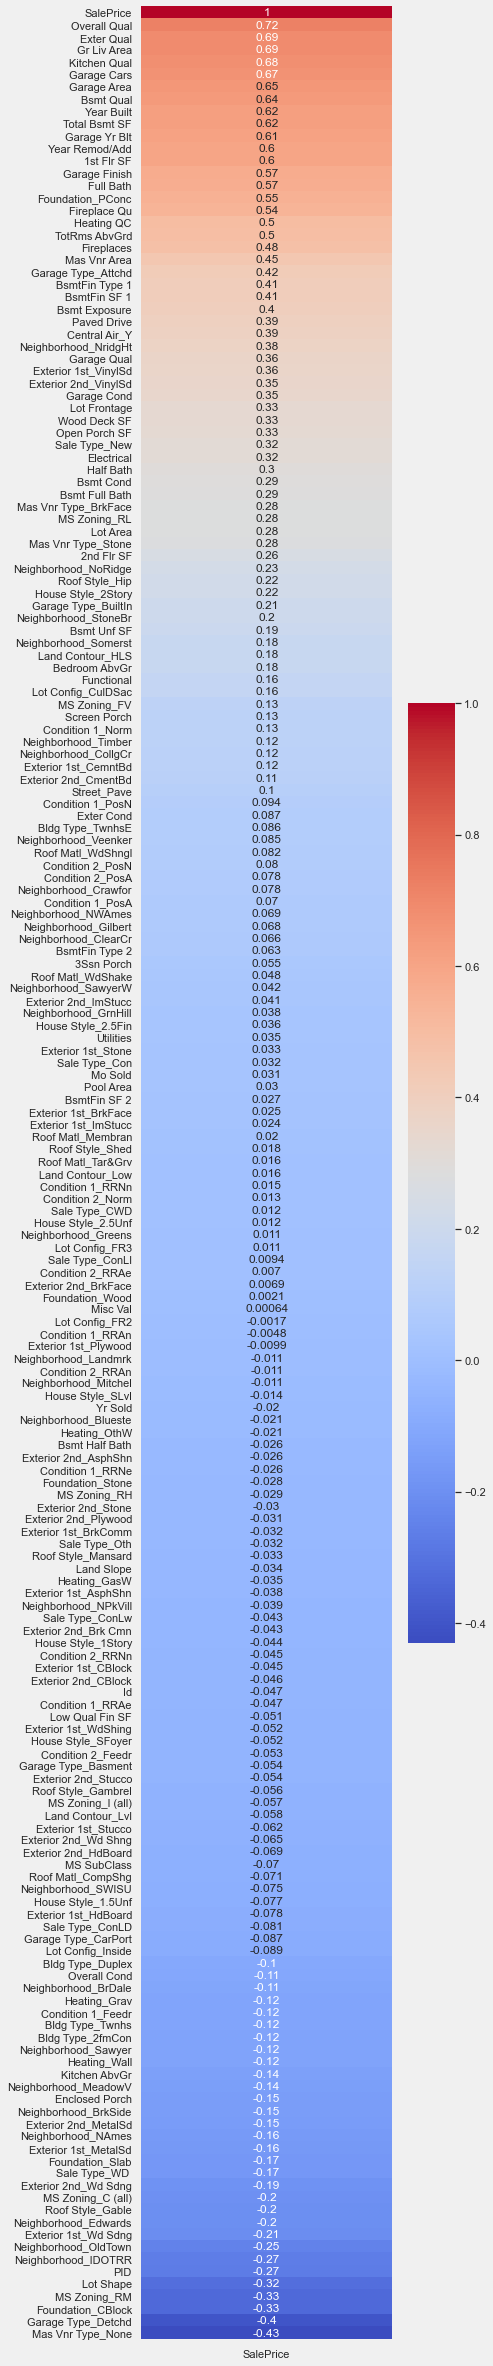

In [91]:
#sorting highest correlation features using heatmap on target salesprice
plt.figure(figsize=(5,40))
sns.set(font_scale=1)
sns.heatmap(Ames_train_clean_df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False), annot=True, cmap='coolwarm');

#### Features with positive significant correlation to sales price:
Overall Qual,Exter Qual,Gr Liv Area,Kitchen Qual,Garage Cars,Total Bsmt SF,Garage Area,,Bsmt Qual,1st Flr SF,Year Built,Year Remod/Add,Fireplace Qu,Full Bath,Garage Yr Blt,Garage Finish,Foundation_PConc,


In [92]:
sig_features=['Exter Qual','Gr Liv Area','Kitchen Qual','Overall Qual','Garage Area','Garage Cars','Total Bsmt SF','1st Flr SF','Bsmt Qual','Year Built','Year Remod/Add','Fireplace Qu','Full Bath','Garage Yr Blt','Foundation_PConc','SalePrice','Garage Finish']
corr=Ames_train_clean_df[sig_features].corr()

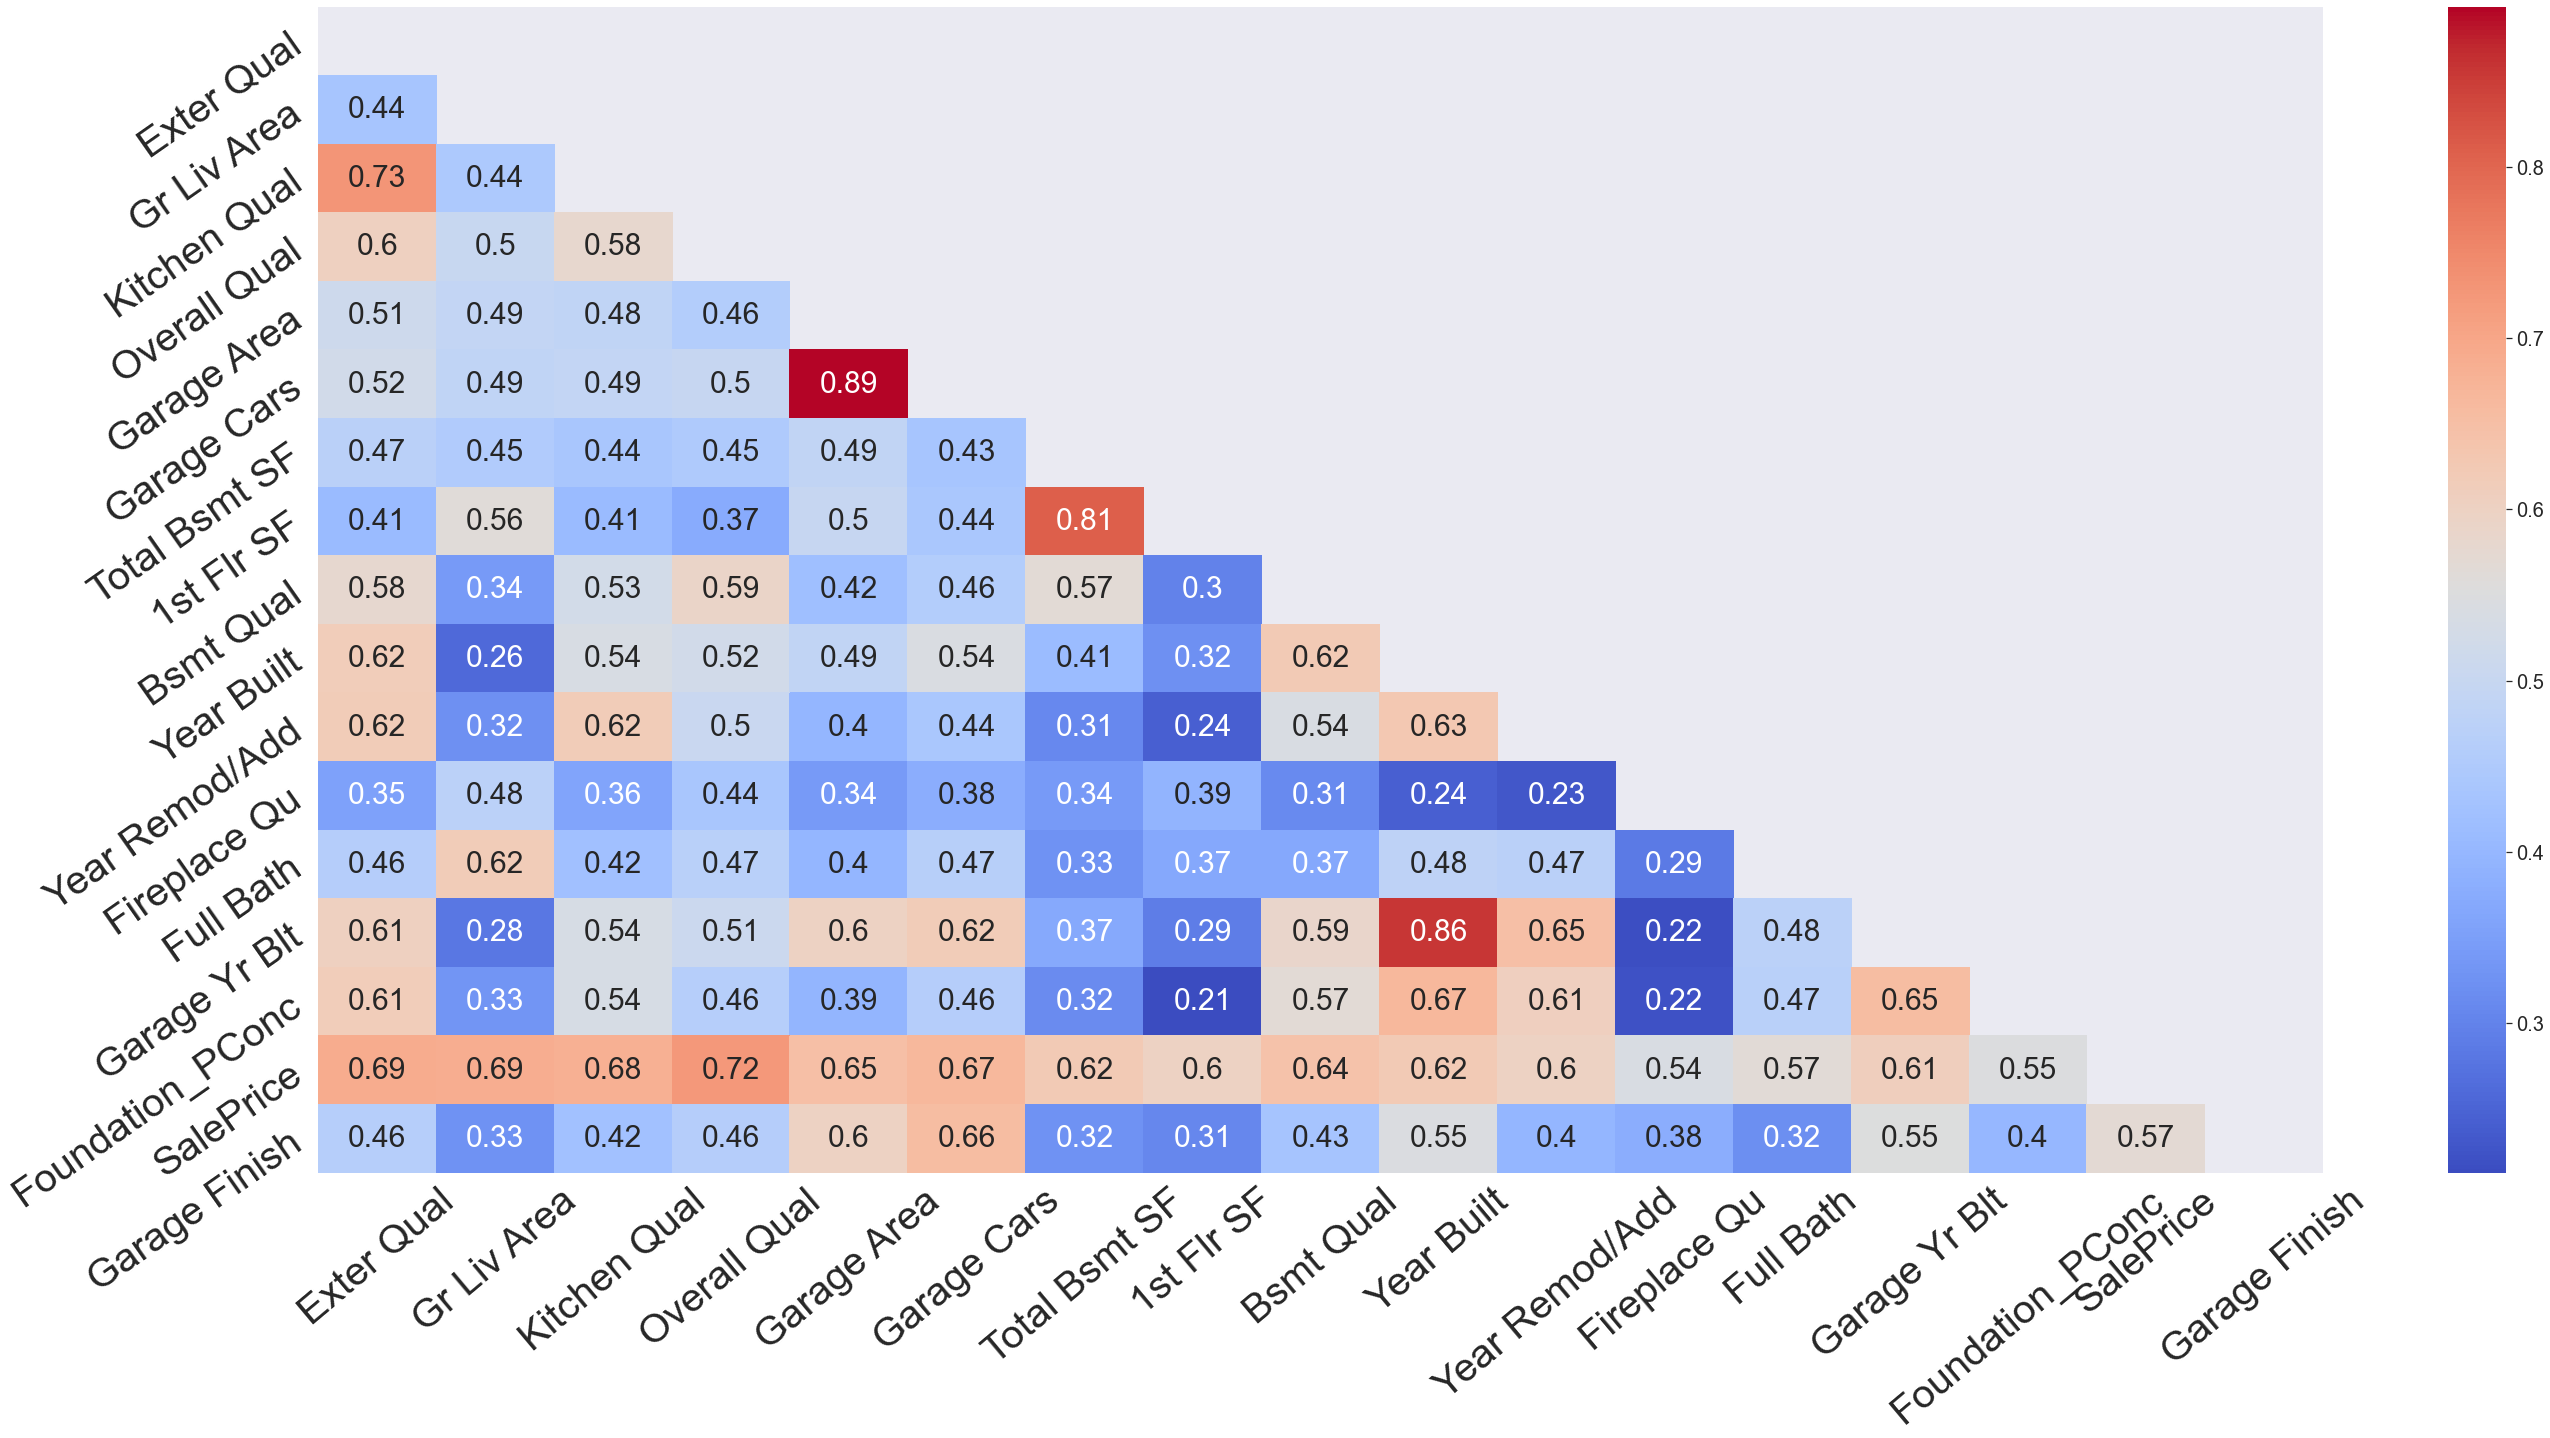

In [93]:
#feature relationship understanding to target
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(40, 20))
res =sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    mask = mask,
    annot_kws={"size": 30},
);

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 40,rotation=40);
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 40,rotation=35);

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)

From the heatmap we can see that some top signicantly correlated features for salesprice have multicollinearity whereby the pearson correlation is >0.5 for some features to the other.
* Garage area and garage cars
* total bsmt SF and 1st Flr SF
* Year built and Garage year built

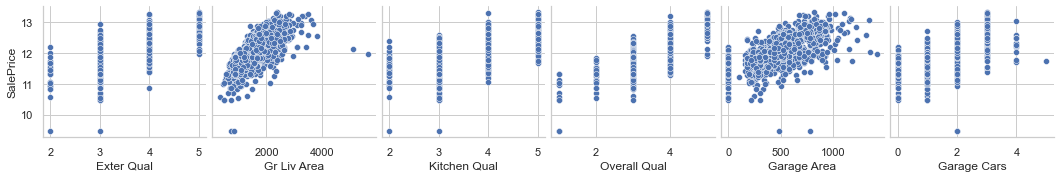

In [94]:
sns.set(style='whitegrid', font_scale=1)
sns.pairplot(data=Ames_train_clean_df,x_vars=['Exter Qual','Gr Liv Area','Kitchen Qual','Overall Qual','Garage Area','Garage Cars'],
             y_vars=['SalePrice']);

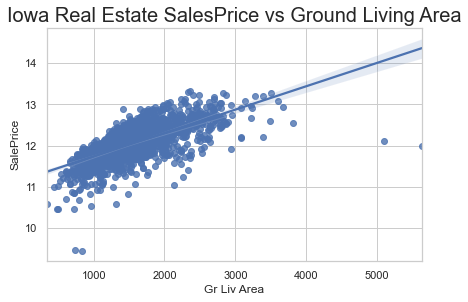

In [95]:
plt.title ('Iowa Real Estate SalesPrice vs Ground Living Area',size=20)
sns.regplot(x="Gr Liv Area", y="SalePrice", data=Ames_train_clean_df);

In [96]:
#every 2k increase in gr living area will cause sale price to increase by
np.exp(13)-np.exp(11.7)

321841.67702247

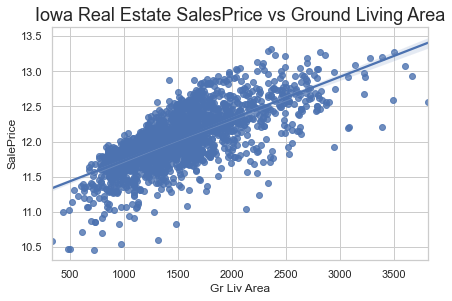

In [97]:
#dropping outliers for gr living area above 4k and salesprice below 9.7 since it doesnt bring value to the typical model building.
Ames_train_clean_df=Ames_train_clean_df.loc[Ames_train_clean_df['Gr Liv Area']<4000]
Ames_train_clean_df=Ames_train_clean_df.loc[Ames_train_clean_df['SalePrice']>9.7]
plt.title ('Iowa Real Estate SalesPrice vs Ground Living Area',size=18)
sns.regplot(x="Gr Liv Area", y="SalePrice", data=Ames_train_clean_df);

In [98]:
#Theres some outlier data after 4000 sqft. but other than that the correlation is very strong

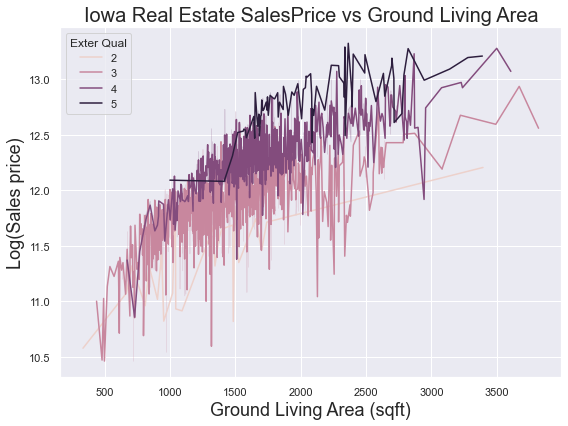

In [99]:
sns.set(rc={"figure.figsize":(8, 6)}) #width=8, height=10
sns.lineplot(x="Gr Liv Area", y="SalePrice", data=Ames_train_clean_df,hue="Exter Qual");
plt.title ('Iowa Real Estate SalesPrice vs Ground Living Area',size=20)
plt.xlabel("Ground Living Area (sqft)", size=18)
plt.ylabel("Log(Sales price)", size=18);
plt.show()

In [100]:
#The external quality has a huge influence on the sales price as well even on the same ground living area.

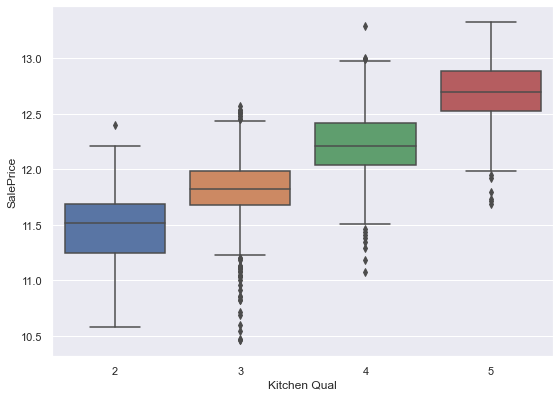

In [101]:
#lets plot a boxplot for salesprice vs kitchen quality.
sns.boxplot(x=Ames_train_clean_df['Kitchen Qual'],y=Ames_train_clean_df['SalePrice']);

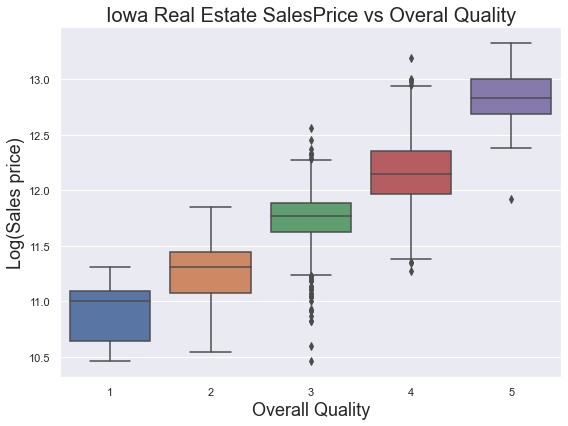

In [102]:
#lets plot a boxplot for salesprice vs overall quality.
sns.boxplot(x=Ames_train_clean_df['Overall Qual'],y=Ames_train_clean_df['SalePrice'])
plt.title('Iowa Real Estate SalesPrice vs Overal Quality',size=20)
plt.xlabel("Overall Quality", size=18)
plt.ylabel("Log(Sales price)", size=18);

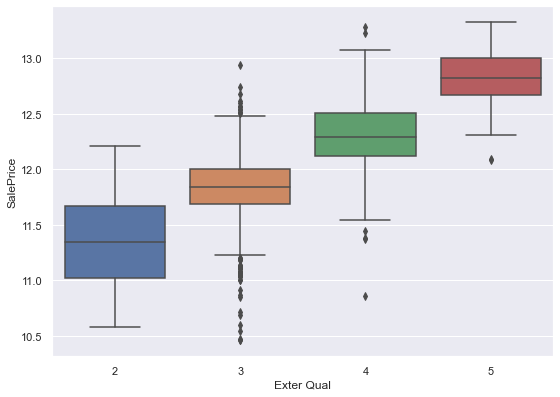

In [103]:
sns.boxplot(x=Ames_train_clean_df['Exter Qual'],y=Ames_train_clean_df['SalePrice']);

In [104]:
#similarly strong increase in salesprice as kitchen,overall and external quality increases.

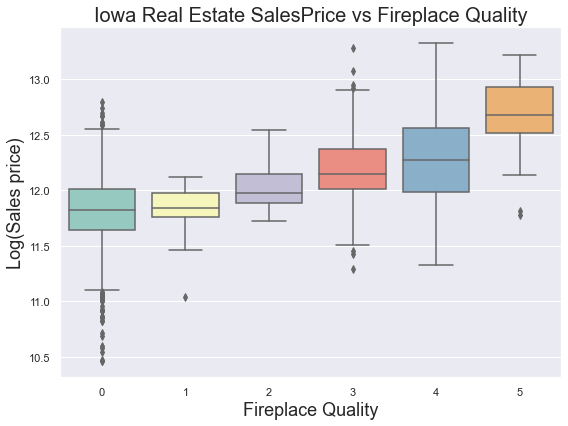

In [105]:
sns.boxplot(x=Ames_train_clean_df['Fireplace Qu'],y=Ames_train_clean_df['SalePrice'],palette="Set3");
plt.title('Iowa Real Estate SalesPrice vs Fireplace Quality',size=20)
plt.xlabel("Fireplace Quality", size=18)
plt.ylabel("Log(Sales price)", size=18);

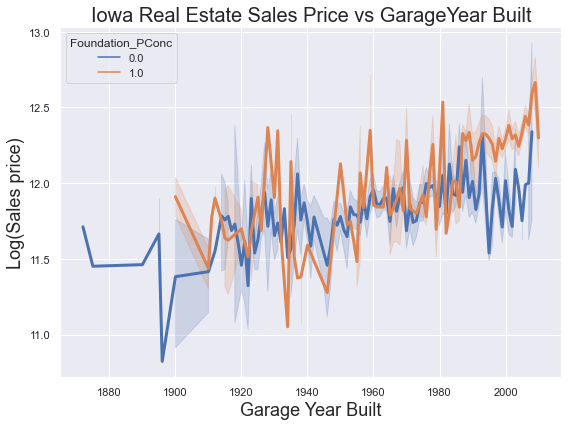

In [106]:
sns.lineplot(x='Garage Yr Blt', y="SalePrice", data=Ames_train_clean_df,hue='Foundation_PConc',linewidth=3);
plt.title('Iowa Real Estate Sales Price vs GarageYear Built',size=20)
plt.xlabel("Garage Year Built", size=18)
plt.ylabel("Log(Sales price)", size=18);

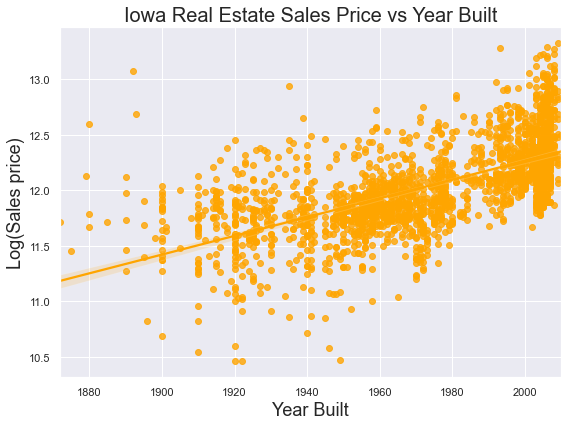

In [107]:
sns.regplot(x='Year Built', y="SalePrice", data=Ames_train_clean_df,color='orange');
plt.title('Iowa Real Estate Sales Price vs Year Built',size=20)
plt.xlabel("Year Built", size=18)
plt.ylabel("Log(Sales price)", size=18);

Garage year built and year built are multicollinear data. ill remove garage year built just to reduce noise.

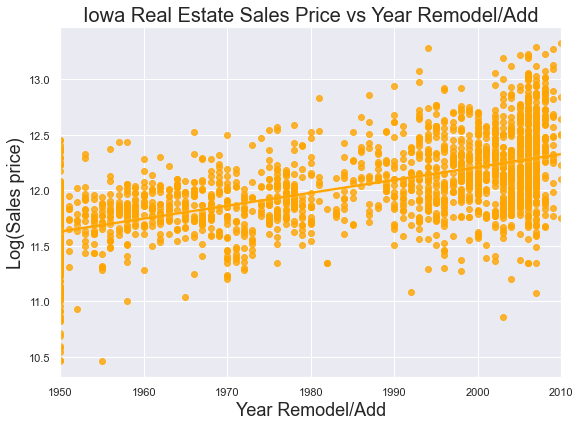

In [108]:
sns.regplot(x='Year Remod/Add', y="SalePrice", data=Ames_train_clean_df,color='orange');
plt.title('Iowa Real Estate Sales Price vs Year Remodel/Add',size=20)
plt.xlabel("Year Remodel/Add", size=18)
plt.ylabel("Log(Sales price)", size=18);

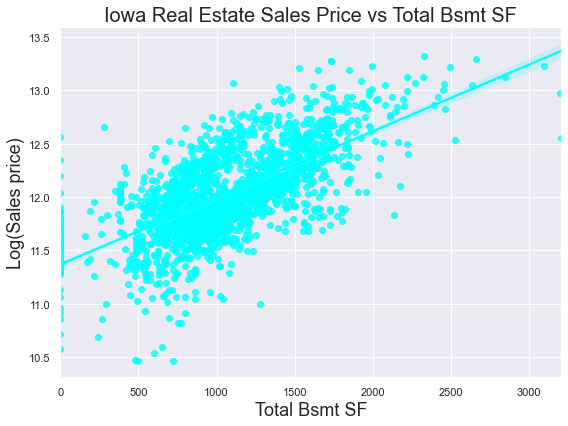

In [109]:
sns.regplot(x='Total Bsmt SF', y="SalePrice", data=Ames_train_clean_df,color='cyan');
plt.title('Iowa Real Estate Sales Price vs Total Bsmt SF',size=20)
plt.xlabel("Total Bsmt SF", size=18)
plt.ylabel("Log(Sales price)", size=18);

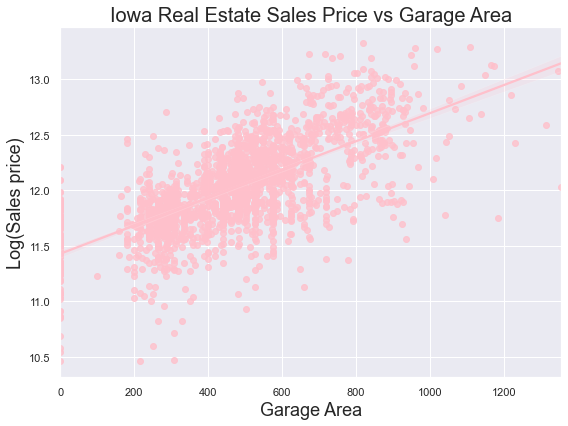

In [110]:
sns.regplot(x='Garage Area', y="SalePrice", data=Ames_train_clean_df,color='pink');
plt.title('Iowa Real Estate Sales Price vs Garage Area',size=20)
plt.xlabel("Garage Area", size=18)
plt.ylabel("Log(Sales price)", size=18);

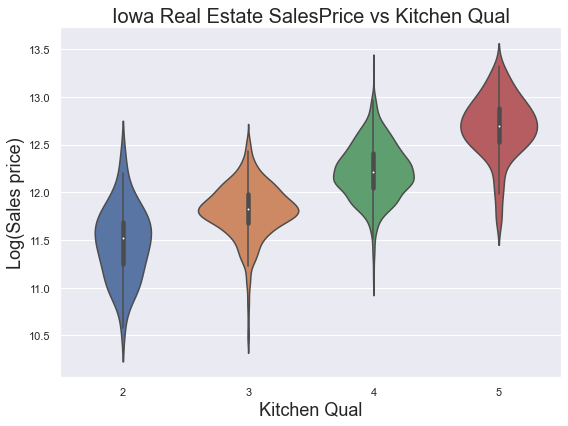

In [111]:
sns.violinplot(x=Ames_train_clean_df['Kitchen Qual'],y=Ames_train_clean_df['SalePrice'])
plt.title('Iowa Real Estate SalesPrice vs Kitchen Qual',size=20)
plt.xlabel("Kitchen Qual", size=18)
plt.ylabel("Log(Sales price)", size=18);

In [112]:
#Feature selection based on heatmap and pearson corr
Features=['Exter Qual','Gr Liv Area','Kitchen Qual','Overall Qual','Garage Area','Garage Cars','Total Bsmt SF','1st Flr SF','Bsmt Qual','Year Built','Year Remod/Add','Full Bath','Garage Yr Blt','Fireplace Qu']
X=Ames_train_clean_df[Features]
y=Ames_train_clean_df['SalePrice']

In [113]:
y[:5]

0    11.779129
1    12.301383
2    11.599103
3    12.066811
4    11.838626
Name: SalePrice, dtype: float64

### Preprocessing and Modeling


In [114]:
from sklearn.model_selection import cross_val_score,train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

#### Preprocess features using standard scalar

In [116]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
Z_train =sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

#### Linear Regression Model

In [117]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(Z_train, y_train) # model fit

LinearRegression(normalize=True)

In [118]:
# Make predictions using sklearn's predict() method
preds = lr.predict(Z_test)
preds[:5]

array([12.58477788, 12.3890055 , 12.77722417, 12.40821528, 12.52953177])

In [119]:
lr.score(X_train,y_train)

-1696222.593951966

In [120]:
lr.score(X_test, y_test)

-1600552.9013087214

In [121]:
#something is wrong, the R2 values are in the negative. this model is not representative to the trend.

In [122]:
lr.coef_

array([ 0.02377376,  0.13376299,  0.03271773,  0.05734902,  0.048583  ,
        0.00297767,  0.0622335 ,  0.0205659 ,  0.0182126 ,  0.05886077,
        0.04610816, -0.02326589, -0.00351935,  0.04055041])

In [123]:
lr.intercept_

12.030273799376653

In [124]:
relation_df = pd.DataFrame(data=X.columns, columns=['Features'])
relation_df['coefficient']=lr.coef_
relation_df.sort_values(by=['coefficient'],ascending=False)

,Features,coefficient
1,Gr Liv Area,0.133763
6,Total Bsmt SF,0.062234
9,Year Built,0.058861
3,Overall Qual,0.057349
4,Garage Area,0.048583
10,Year Remod/Add,0.046108
13,Fireplace Qu,0.040550
2,Kitchen Qual,0.032718
0,Exter Qual,0.023774
7,1st Flr SF,0.020566


In [125]:
# RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, preds))

0.156085497153522

In [126]:
#quite low for RMSE but we can see the Train and test score is very bad.

#### Ridge Regression

In [127]:
#Lets try Ridge regularization
# Ridge regression with "built-in" cross-validation (advancing from above approach w/o cv)
from sklearn.linear_model import Ridge

#instantiate ridge regression
ridge=Ridge()

In [128]:
#create pipeline
from sklearn.pipeline import Pipeline

pipe_ridge=Pipeline([
    ('sc',sc),
    ('ridge',ridge)
])

In [129]:
pipe_ridge.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('ridge', Ridge())],
 'verbose': False,
 'sc': StandardScaler(),
 'ridge': Ridge(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [130]:
ridge_params={'sc__with_mean':[True,False],
             'sc__with_std':[True,False],
             'ridge__alpha': np.logspace(0, 5, 100),
             'ridge__normalize': [True,False],
              'ridge__fit_intercept': [True,False],
              'ridge__max_iter': [100]
             }

In [131]:
gs_ridge=GridSearchCV(pipe_ridge,ridge_params,cv=5,verbose=1)

In [132]:
gs_ridge.fit(X_train,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.7...
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
                         'ridge__fit_intercept': [True, False],
                         'ridge__max_iter': [100],
                         'ridge__normalize': [True, False],
                         'sc__with_mean': [True, False],
                     

In [133]:
gs_ridge.best_score_

0.8709452482551747

In [134]:
gs_ridge.best_estimator_

Pipeline(steps=[('sc', StandardScaler()),
                ('ridge', Ridge(alpha=18.30738280295368, max_iter=100))])

In [135]:
gs_ridge.score(X_train,y_train)

0.874988889731249

In [136]:
gs_ridge.score(X_test,y_test)

0.8594352954593194

In [137]:
ridge_pred=gs_ridge.predict(X_test)

In [138]:
#Fitting using the optimized alpha from gridsearch to get ridge coefficient.

ridge1 = Ridge(alpha=18.3074,max_iter=100).fit(Z_train, y_train)# fitting 5-fold CV

print(ridge1.score(Z_train, y_train))
print(ridge1.score(Z_test, y_test))


0.874988889601229
0.8594352956340521


In [139]:
train_score_list=[]
test_score_list=[]
alpha_list=[]
def ridge_alpha(alpha):
    for a in alpha:
        ridge_test = Ridge(alpha=a,max_iter=100).fit(Z_train, y_train)
        train_score_list.append(ridge_test.score(Z_train, y_train))
        test_score_list.append(ridge_test.score(Z_test, y_test))
        alpha_list.append(a)


In [140]:
ridge_alpha([1,5,10,15,20,25,30,35,40])

In [141]:
alpha_list

[1, 5, 10, 15, 20, 25, 30, 35, 40]

In [142]:
train_score_list

[0.8750633763111759,
 0.8750573928268423,
 0.8750397346282359,
 0.8750120795407271,
 0.8749756364119496,
 0.874931441094751,
 0.8748803859506604,
 0.8748232435245886,
 0.8747606856898884]

In [143]:
ridge_df = pd.DataFrame(
    {'alpha': alpha_list,
     'train_score': train_score_list,
     'test_score': test_score_list
    })
ridge_df

,alpha,train_score,test_score
0,1,0.875063,0.859183
1,5,0.875057,0.859256
2,10,0.875040,0.859334
3,15,0.875012,0.859399
4,20,0.874976,0.859452
5,25,0.874931,0.859494
6,30,0.874880,0.859525
7,35,0.874823,0.859548
8,40,0.874761,0.859562


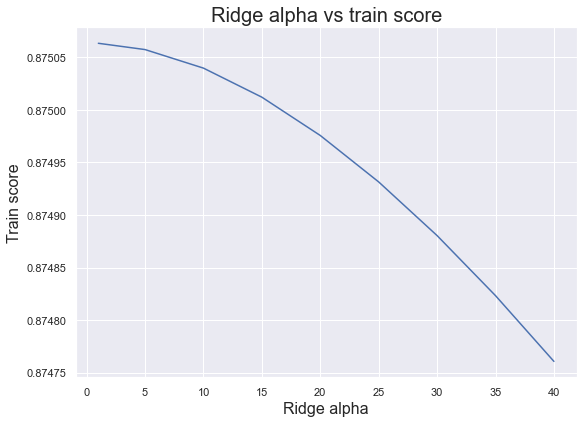

In [144]:
# plotting scatterplot with histograms for features total bill and tip.
sns.lineplot(data=ridge_df, x="alpha", y="train_score");
plt.title('Ridge alpha vs train score',size=20);
plt.xlabel('Ridge alpha',size=16);
plt.ylabel('Train score',size=16);

In [145]:
relation_ridge_df = pd.DataFrame(data=X.columns, columns=['Features'])
relation_ridge_df ['coefficient']=ridge1.coef_
relation_ridge_df .sort_values(by=['coefficient'],ascending=False)

,Features,coefficient
1,Gr Liv Area,0.129661
6,Total Bsmt SF,0.059768
3,Overall Qual,0.056916
9,Year Built,0.054719
4,Garage Area,0.045997
10,Year Remod/Add,0.044966
13,Fireplace Qu,0.040790
2,Kitchen Qual,0.033025
0,Exter Qual,0.024656
7,1st Flr SF,0.023336


In [146]:
ridge_res_df1 = pd.DataFrame(
    {'y_actual': y_test,
     'ridge_pred': ridge_pred,
    })
ridge_res_df1.head()

,y_actual,ridge_pred
1477,12.675764,12.586365
693,12.367885,12.389027
100,12.866180,12.780888
1829,12.411867,12.407505
1764,12.577636,12.528644


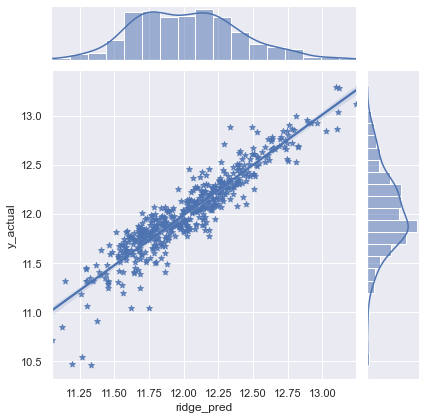

In [147]:
sns.jointplot(data=ridge_res_df1, x="ridge_pred", y="y_actual", kind="reg", marker="*");
plt.xlabel('ridge_pred',size=16);
plt.ylabel('y_actual',size=16);

In [148]:
# RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, ridge_pred))

0.1559343991334955

slightly overfit but overall R2 is higher and RMSE is lower which is much better than purely running the model with linear regression w/o regularization via ridge.

#### Lasso regression

In [149]:
#Let's try Lasso regularization
# Imports similar to Ridge, this time for Lasso instead
from sklearn.linear_model import Lasso, LassoCV
#instantiate lasso regression
lasso=Lasso()

In [150]:
#create pipeline

pipe_lasso=Pipeline([
    ('sc',sc),
    ('lasso',lasso)
])

In [151]:
pipe_lasso.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('lasso', Lasso())],
 'verbose': False,
 'sc': StandardScaler(),
 'lasso': Lasso(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': None,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [152]:
lasso_params={'sc__with_mean':[True,False],
             'sc__with_std':[True,False],
             'lasso__alpha': np.linspace(0.01, 1.0, 10),
             'lasso__normalize': [True,False],
              'lasso__fit_intercept': [True,False],
              'lasso__max_iter': [1000],
              'lasso__tol': [0.001]
             }

In [153]:
gs_lasso=GridSearchCV(pipe_lasso,lasso_params,cv=5,verbose=1)

In [154]:
gs_lasso.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'lasso__fit_intercept': [True, False],
                         'lasso__max_iter': [1000],
                         'lasso__normalize': [True, False],
                         'lasso__tol': [0.001], 'sc__with_mean': [True, False],
                         'sc__with_std': [True, False]},
             verbose=1)

In [155]:
gs_lasso.best_score_

0.8690257764706015

In [156]:
gs_lasso.best_estimator_

Pipeline(steps=[('sc', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, tol=0.001))])

In [157]:
gs_lasso.score(X_train,y_train)

0.8721726686261955

In [158]:
gs_lasso.score(X_test,y_test)

0.854337810433777

In [159]:
lasso_pred=gs_lasso.predict(X_test)

In [160]:
# RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, lasso_pred))

0.15873664831562873

Compared to ridge, lasso is performing worse with a lower R2 score for train and test set. the RMSE is also higher.

#### Elastic Net Regression

In [161]:
from sklearn.linear_model import ElasticNet

#instantiate elasticnet regression
enet=ElasticNet()

In [162]:
#create pipeline

pipe_enet=Pipeline([
    ('sc',sc),
    ('enet',enet)
])

In [163]:
pipe_enet.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('enet', ElasticNet())],
 'verbose': False,
 'sc': StandardScaler(),
 'enet': ElasticNet(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'enet__alpha': 1.0,
 'enet__copy_X': True,
 'enet__fit_intercept': True,
 'enet__l1_ratio': 0.5,
 'enet__max_iter': 1000,
 'enet__normalize': False,
 'enet__positive': False,
 'enet__precompute': False,
 'enet__random_state': None,
 'enet__selection': 'cyclic',
 'enet__tol': 0.0001,
 'enet__warm_start': False}

In [164]:
enet_params={'sc__with_mean':[True,False],
             'sc__with_std':[True,False],
             'enet__alpha': np.linspace(0.5, 1.0, 10),
             'enet__normalize': [True,False],
              'enet__fit_intercept': [True,False],
              'enet__max_iter': [1000],
              'enet__tol': [0.01],
             }

In [165]:
gs_enet=GridSearchCV(pipe_enet,enet_params,cv=5,verbose=1)

In [166]:
gs_enet.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('enet', ElasticNet())]),
             param_grid={'enet__alpha': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ]),
                         'enet__fit_intercept': [True, False],
                         'enet__max_iter': [1000],
                         'enet__normalize': [True, False], 'enet__tol': [0.01],
                         'sc__with_mean': [True, False],
                         'sc__with_std': [True, False]},
             verbose=1)

In [167]:
gs_enet.best_score_

0.8280939927847897

In [168]:
gs_enet.best_estimator_

Pipeline(steps=[('sc', StandardScaler(with_mean=False, with_std=False)),
                ('enet', ElasticNet(alpha=0.5, tol=0.01))])

In [169]:
gs_enet.score(X_train,y_train)

0.8309839312624083

In [170]:
gs_enet.score(X_test,y_test)

0.8102359716274992

In [171]:
enet_pred=gs_enet.predict(X_test)

In [172]:
# RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, enet_pred))

0.18118019997214413

Elastic net not suitable to be used here unfortunately. Eventhough RMSE is bettern 0.2 to 0.5 which has good accuracy but the R2 is lower than ridge or lasso meaning its not good at predicting the model accurately.

#### Feature Engineering: Reducing multicollinear features to reduce overfitting

In [173]:
#trying to merge multicollinear factors together to reduce noise.

#We will add up all the individual SF from the bsmt, 1st floor and 2nd floor to get a better picture of the total SF.
Ames_train_clean_df['TotalSF']=Ames_train_clean_df['Total Bsmt SF']+Ames_train_clean_df['1st Flr SF']+Ames_train_clean_df['2nd Flr SF']
Ames_test_clean_df['TotalSF']=Ames_test_clean_df['Total Bsmt SF']+Ames_test_clean_df['1st Flr SF']+Ames_test_clean_df['2nd Flr SF']

#When buyers look for number of bathrooms they will not have time to look into each type. We will sum this up as well.
Ames_train_clean_df['totalBathRoom']=Ames_train_clean_df['Full Bath']+Ames_train_clean_df['Bsmt Full Bath']+0.5*(Ames_train_clean_df['Bsmt Half Bath']+Ames_train_clean_df['Half Bath'])
Ames_test_clean_df['totalBathRoom']=Ames_test_clean_df['Full Bath']+Ames_test_clean_df['Bsmt Full Bath']+0.5*(Ames_test_clean_df['Bsmt Half Bath']+Ames_test_clean_df['Half Bath'])

#We also need to look into the delta for year sold and year built since houses sold in the year it is built usually fetch better pricing.
Ames_train_clean_df['HouseAge']=Ames_train_clean_df['Yr Sold']-Ames_train_clean_df['Year Built']
Ames_test_clean_df['HouseAge']=Ames_test_clean_df['Yr Sold']-Ames_test_clean_df['Year Built']

#Adding a feature to check if the house is remodelled as it was built? gives it an added advantage.
#Ames_train_clean_df['Remodeled']=np.where(Ames_train_clean_df['Year Remod/Add']==Ames_train_clean_df['Year Built'],0,1)
#Ames_test_clean_df['Remodeled']=np.where(Ames_test_clean_df['Year Remod/Add']==Ames_test_clean_df['Year Built'],0,1)

#Adding a feature to check if the house is sold the same year it was built
Ames_train_clean_df['isNew']=np.where(Ames_train_clean_df['Yr Sold']==Ames_train_clean_df['Year Built'],0,1)
Ames_test_clean_df['isNew']=np.where(Ames_test_clean_df['Yr Sold']==Ames_test_clean_df['Year Built'],1,0)                                 

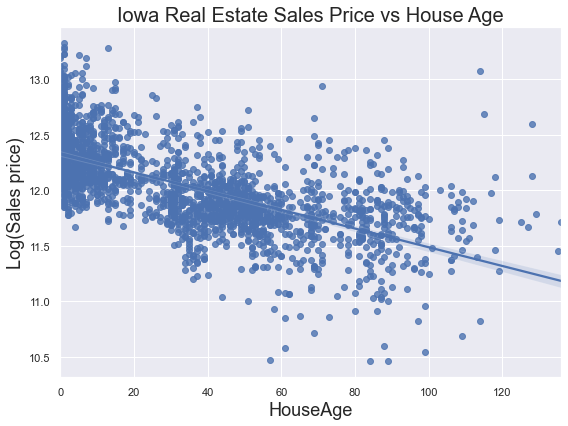

In [174]:
sns.regplot(x='HouseAge', y="SalePrice", data=Ames_train_clean_df);
plt.title('Iowa Real Estate Sales Price vs House Age',size=20)
plt.xlabel("HouseAge", size=18)
plt.ylabel("Log(Sales price)", size=18);

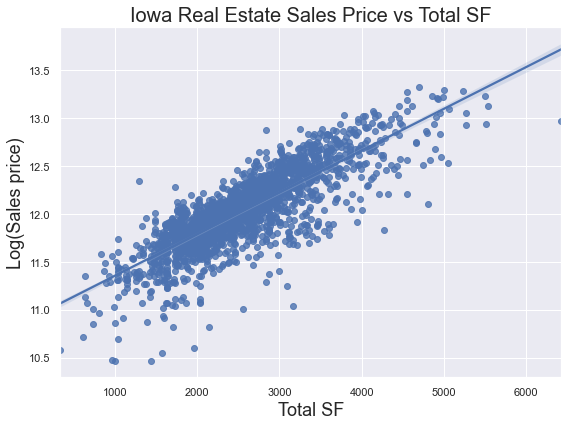

In [175]:
sns.regplot(x='TotalSF', y="SalePrice", data=Ames_train_clean_df);
plt.title('Iowa Real Estate Sales Price vs Total SF',size=20)
plt.xlabel("Total SF", size=18)
plt.ylabel("Log(Sales price)", size=18);

In [176]:
#we should also improve skewed data.
skewness=Ames_train_clean_df.skew().sort_values(ascending=False)
skewness[abs(skewness)>0.75]

Neighborhood_Landmrk    45.243784
Roof Matl_Membran       45.243784
Exterior 1st_AsphShn    45.243784
MS Zoning_I (all)       45.243784
Condition 2_RRAn        45.243784
Exterior 1st_ImStucc    45.243784
Condition 2_RRAe        45.243784
Foundation_Wood         31.968712
Neighborhood_GrnHill    31.968712
Exterior 2nd_CBlock     31.968712
Heating_OthW            31.968712
Condition 2_RRNn        31.968712
Exterior 1st_Stone      31.968712
Exterior 1st_CBlock     31.968712
Exterior 1st_BrkComm    26.083169
Condition 2_PosN        26.083169
Condition 2_PosA        26.083169
Condition 1_RRNe        26.083169
Roof Style_Shed         26.083169
Neighborhood_Greens     26.083169
Exterior 2nd_AsphShn    26.083169
Roof Matl_WdShake       22.572074
Sale Type_Con           22.572074
Sale Type_Oth           22.572074
Foundation_Stone        20.174212
Sale Type_ConLw         20.174212
Heating_Wall            20.174212
Roof Matl_WdShngl       20.174212
Heating_Grav            20.174212
Misc Val      

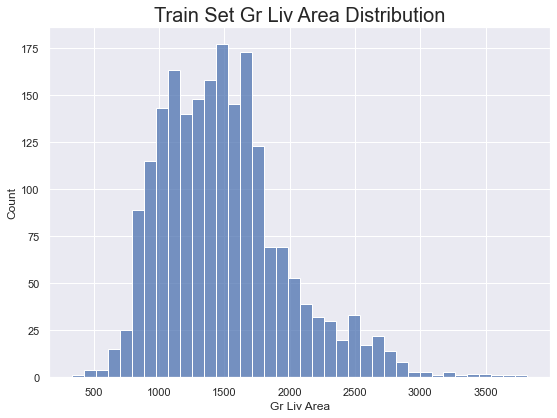

In [177]:
sns.histplot(data=Ames_train_clean_df['Gr Liv Area']);
plt.title('Train Set Gr Liv Area Distribution',size=20);
#gr living area is slightly skewed to the right

In [178]:
#using logarithm to reduce the skewness.
Ames_train_clean_df['Gr Liv Area']=np.log(Ames_train_clean_df['Gr Liv Area'])

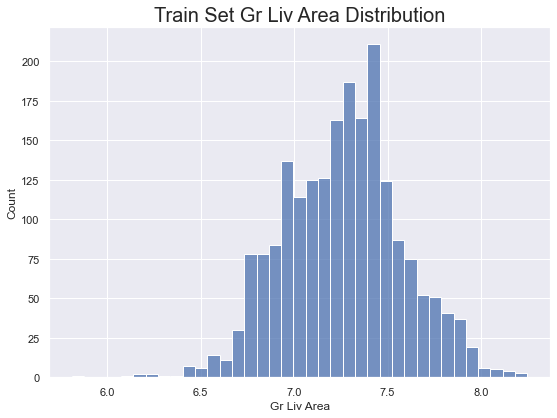

In [179]:
sns.histplot(data=Ames_train_clean_df['Gr Liv Area']);
plt.title('Train Set Gr Liv Area Distribution',size=20);

In [180]:
#we should also improve skewed data.
skewness_test=Ames_test_clean_df.skew().sort_values(ascending=False)
skewness_test[abs(skewness_test)>0.75]

Exterior 2nd_CBlock     29.631065
Exterior 2nd_AsphShn    29.631065
MS Zoning_I (all)       29.631065
Exterior 1st_AsphShn    29.631065
Condition 2_PosA        29.631065
Mas Vnr Type_CBlock     29.631065
Sale Type_VWD           29.631065
Exterior 2nd_Other      29.631065
Roof Matl_Metal         29.631065
Roof Matl_Roll          29.631065
Sale Type_Con           29.631065
Exterior 2nd_PreCast    29.631065
Exterior 1st_PreCast    29.631065
Misc Val                25.539214
Sale Type_CWD           20.916419
Roof Matl_WdShngl       20.916419
Sale Type_ConLI         20.916419
Roof Style_Shed         20.916419
House Style_2.5Fin      20.916419
Foundation_Wood         17.048838
Sale Type_ConLw         17.048838
Condition 1_RRNe        17.048838
Sale Type_Oth           17.048838
Condition 1_RRNn        17.048838
Exterior 1st_BrkComm    17.048838
Pool Area               16.699206
Garage Type_CarPort     14.739287
Heating_Grav            14.739287
Exterior 2nd_ImStucc    14.739287
Roof Style_Man

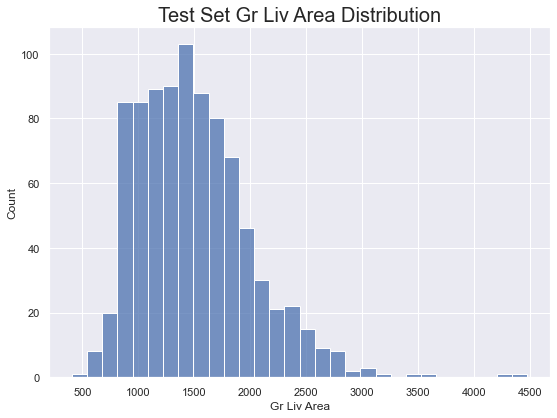

In [181]:
sns.histplot(data=Ames_test_clean_df['Gr Liv Area']);
plt.title('Test Set Gr Liv Area Distribution',size=20);
#gr living area is slightly skewed to the right

In [182]:
#using logarithm to reduce the skewness.
Ames_test_clean_df['Gr Liv Area']=np.log(Ames_test_clean_df['Gr Liv Area'])

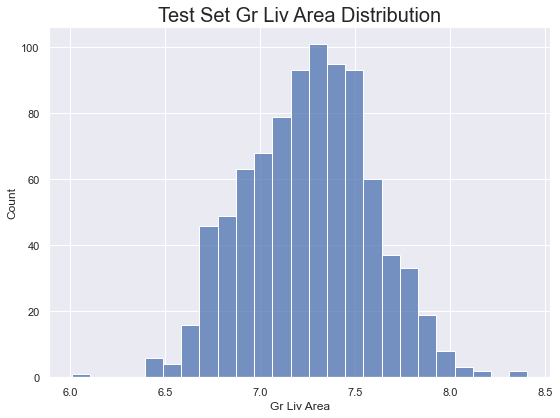

In [183]:
sns.histplot(data=Ames_test_clean_df['Gr Liv Area']);
plt.title('Test Set Gr Liv Area Distribution',size=20);

Gr living area better matches normal distribution after using logarithm scale

In [184]:
#At this point, i decided to use Ridge since its one of the best but we might need to remove some features to improve accuracy.
#lets try remove full bath since its the minor multicollinear feature.
reduced_features=['TotalSF','Exter Qual','Gr Liv Area','Kitchen Qual','Overall Qual','Garage Area','Garage Cars','Bsmt Qual','Fireplace Qu','Garage Finish','HouseAge','Year Remod/Add','totalBathRoom','isNew']
X=Ames_train_clean_df[reduced_features]
y=Ames_train_clean_df['SalePrice']
#in the end we decided to drop the Remodelled binary feature because it doest yield a good score.

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [186]:
sc=StandardScaler()
Z_train =sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [187]:
# Ridge regression with "built-in" cross-validation (advancing from above approach w/o cv)
from sklearn.linear_model import Ridge

#instantiate ridge regression
ridge2=Ridge()


In [188]:
pipe2_ridge=Pipeline([
    ('sc',sc),
    ('ridge',ridge)
])

In [189]:
ridge2_params={'sc__with_mean':[True,False],
             'sc__with_std':[True,False],
             'ridge__alpha': np.logspace(0, 5, 100),
             'ridge__normalize': [True,False],
              'ridge__fit_intercept': [True,False],
              'ridge__max_iter': [100]
             }

In [190]:
gs_ridge2=GridSearchCV(pipe2_ridge,ridge2_params,cv=5,verbose=1)

In [191]:
gs_ridge2.fit(X_train,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.7...
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
                         'ridge__fit_intercept': [True, False],
                         'ridge__max_iter': [100],
                         'ridge__normalize': [True, False],
                         'sc__with_mean': [True, False],
                     

In [192]:
gs_ridge2.best_score_

0.8741031114621748

In [193]:
gs_ridge2.best_estimator_

Pipeline(steps=[('sc', StandardScaler(with_std=False)),
                ('ridge', Ridge(alpha=11.497569953977356, max_iter=100))])

In [194]:
gs_ridge2.score(X_train,y_train)

0.877566455492738

In [195]:
gs_ridge2.score(X_test,y_test)

0.8632959533764079

In [196]:
ridge2_pred=gs_ridge2.predict(X_test)

In [197]:
# RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, ridge2_pred))

0.15377809420607932

### Summary of models
The results from the models that we have tested to predict the correlation on the Ames Iowa data set features and its sale price.

| Model            | Penalty     | Value of a | Training Acuracy | Testing Acuracy | RMSE   | Interpretation/Conclusion                                                                                                                           |
|:------------------|:-------------|:------------:|:------------------|:-----------------|:--------|:-----------------------------------------------------------------------------------------------------------------------------------------------------|
| linear regession | NA          | NA         | -1696222         | -1600552        | 0.1561 | 15 features. train and test score is negative which is a poor fit to the model.                                                                     |
| pipe1_ridge      | RIDGE       | 16.30      | 0.8750           | 0.8594          | 0.1559 | 15 features. train and test score better than linear reg, RMSE on the lower side which is better as well.                                           |
| pipe1_lasso      | LASSO       | 0.01       | 0.8722           | 0.8543          | 0.1587 | 15 features. train and test score slightly lower than ridge. RMSE also higher than ridge. Ridge has better fit and accuracy.                        |
| pipe1_elasticnet | ELASTIC NET | 0.5        | 0.8310           | 0.8102          | 0.1811 | 15 features. train and test score lower than both ridge and lasso. RMSE also higher than ridge and lasso. Ridge has better fit and accuracy.        |
| pipe2_ridge      | RIDGE       | 11.50         | 0.8776            | 0.8633          | 0.1538 | 14 features+ skewness correction. Combined features give better R2 score for train and test. RMSE is also lower in the reduced feature ridge model. |

As a whole, Ridge regression with combined features and skewness reduction gives the best r2 score for train and test set. The RMSE is also lower than linear regression,lasso and elastic net. We can deduce that this model gives the best accuracy to predict the sales price for the train and test set.

#### Test SalesPrice Prediction

In [198]:
Ames_test_clean_df.columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Area', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       ...
       'Sale Type_ConLw', 'Sale Type_New', 'Sale Type_Oth', 'Sale Type_VWD',
       'Sale Type_WD ', 'Lot Frontage', 'TotalSF', 'totalBathRoom', 'HouseAge',
       'isNew'],
      dtype='object', length=184)

In [199]:
Features

['Exter Qual',
 'Gr Liv Area',
 'Kitchen Qual',
 'Overall Qual',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Bsmt Qual',
 'Year Built',
 'Year Remod/Add',
 'Full Bath',
 'Garage Yr Blt',
 'Fireplace Qu']

In [200]:
#Lets try this model in predicting the real test set
X_test=Ames_test_clean_df[reduced_features]
X_test.shape

(878, 14)

In [201]:
X_test.head()

,TotalSF,Exter Qual,Gr Liv Area,Kitchen Qual,Overall Qual,Garage Area,Garage Cars,Bsmt Qual,Fireplace Qu,Garage Finish,HouseAge,Year Remod/Add,totalBathRoom,isNew
0,2948,3,7.564238,2,4,440,1,2,0,3,96,1950,2.0,0
1,3934,3,7.584265,3,3,580,2,4,0,5,29,1977,2.0,0
2,2150,4,7.310550,4,4,426,2,4,4,4,0,2006,3.5,1
3,1936,4,6.875232,3,3,480,2,3,0,3,84,2006,1.0,0
4,2788,3,7.239933,3,4,514,2,4,4,4,46,1963,2.5,0


In [202]:
X.shape

(2047, 14)

In [203]:
y[:3]

0    11.779129
1    12.301383
2    11.599103
Name: SalePrice, dtype: float64

In [204]:
#instantiate ridge regression
sc=StandardScaler()
ridge_test=Ridge()


In [205]:
pipe_test_ridge=Pipeline([
    ('sc',sc),
    ('ridge',ridge_test)
])

In [206]:
ridge_test_params={'sc__with_mean':[True,False],
             'sc__with_std':[True,False],
             'ridge__alpha': np.logspace(0, 5, 100),
             'ridge__normalize': [True,False],
              'ridge__fit_intercept': [True,False],
              'ridge__max_iter': [100]
             }

In [207]:
gs_test_ridge=GridSearchCV(pipe_test_ridge,ridge_test_params,cv=5,verbose=1)

In [208]:
gs_test_ridge.fit(X,y)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.7...
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
                         'ridge__fit_intercept': [True, False],
                         'ridge__max_iter': [100],
                         'ridge__normalize': [True, False],
                         'sc__with_mean': [True, False],
                     

In [209]:
gs_test_ridge.best_score_

0.8726660955363095

In [210]:
gs_test_ridge.score(X,y)

0.8744683270847918

In [211]:
gs_test_ridge.best_estimator_

Pipeline(steps=[('sc', StandardScaler(with_std=False)),
                ('ridge', Ridge(alpha=12.91549665014884, max_iter=100))])

In [212]:
ridge_test_pred=gs_test_ridge.predict(X_test)

In [213]:
#getting back the inverse of log for salesprice
ridge_pred_final=np.exp(ridge_test_pred)
ridge_pred_final[:5]

array([143399.30332626, 209692.06742543, 201610.44180919, 124215.21171088,
       184308.58609872])

In [214]:
test_salesprice_df = pd.DataFrame({'Id':Ames_test['Id'], 'SalePrice':ridge_pred_final})

In [215]:
test_salesprice_df.to_csv('test_salesprice1_df.csv', index=False)

### Kaggle submission Score
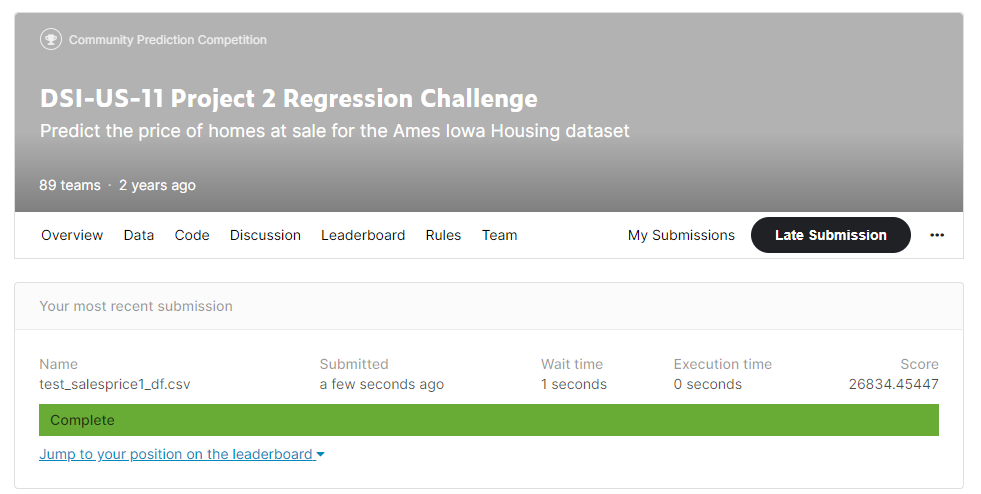

### Conclusion and Recommendations

In conclusion, from the models that we have tested it shows ridge have the best r2 score and lower RMSE for better fit and accuracy in determining the target salesprice. The features with the highest ridge coefficient tells us that area, quality and built year has the most influence on the sales price in Ames Iowa housing. We use this knowledge that we learn to predict the salesprice for the test set which helps us as real estate agents to position ourselfs in a more market competitive edge to recommend to clients on suitable housings. 

The recommendations we have for buyers that wish to upscale their property to fetch better pricing is to buy houses with bigger living area and renovate it with better quality finishings and a fireplace to get better investment returns.


### References
* https://nycdatascience.com/blog/student-works/house-price-prediction-in-ames-iowa/
* http://jse.amstat.org/v19n3/decock/DataDocumentation.txt